# Neural networks

### Libraries


In [1]:
from imblearn.pipeline import Pipeline
import pandas as pd
import numpy as np
from scipy import stats
import tensorflow as tf
import keras
import os
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from imblearn.pipeline import make_pipeline 
from keras.wrappers.scikit_learn import KerasClassifier
from imblearn.over_sampling import SMOTENC, RandomOverSampler
from imblearn.combine import SMOTEENN

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline 
from Project2_neuralnetworks_support import *
import time
from sklearn.model_selection import StratifiedKFold
from skopt import BayesSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

### Importing data

In [2]:
# Read the two datasets from the pickle files
dir_path = os.getcwd()

X_tr = pd.read_pickle(dir_path + "\\data\\X_train_log.pkl")
X_te = pd.read_pickle(dir_path + "\\data\\X_test_log.pkl")


y_train = pd.read_pickle(dir_path + "\\data\\y_train.pkl")
y_test = pd.read_pickle(dir_path + "\\data\\y_test.pkl")

### Normalizing the data

In [3]:
from sklearn.preprocessing import MinMaxScaler
columns = X_tr.columns

scaler = MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_tr), columns= columns)
X_test = pd.DataFrame(scaler.transform(X_te), columns= columns)


## GridsearchCV with RandomUndersampling a NN

In [4]:
n_iter = 70
epochs = 15

In [5]:
# nn base function
def create_nn_model(n_neurons_1=40, n_neurons_2=20, dropout=0.1, learning_rate=0.001):
    model = keras.models.Sequential([
    keras.layers.Dense(n_neurons_1,activation="relu"),
    keras.layers.Dropout(dropout),
    keras.layers.Dense(n_neurons_2,activation="relu"),
    keras.layers.Dropout(dropout),
    keras.layers.Dense(1,activation="sigmoid"),])
    
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

    return model



In [6]:
model = KerasClassifier(build_fn=create_nn_model, epochs=epochs, batch_size=10, initial_epoch=0, verbose=0)

# Parameters
n_neurons = [2, 4, 8, 16, 32, 64, 124]
dropouts = [0.01, 0.001, 0] 


# Pipeline
smote_pipe_cnn = Pipeline([("under", RandomUnderSampler()), ("model", model)])

# GridsearchCV
param_grid = dict(model__n_neurons_1=n_neurons, model__n_neurons_2=n_neurons, model__dropout=dropouts)
grid = RandomizedSearchCV(smote_pipe_cnn, param_distributions=param_grid, n_iter=n_iter, n_jobs=-1, verbose=1, scoring='f1')

start = time.time()
grid_result_nn_1 = grid.fit(X_train, y_train)
end = time.time()

print("Process time:", end - start)
print("Best parameters:", grid_result_nn_1.best_params_)
print("average f1 score:", grid_result_nn_1.cv_results_["mean_test_score"].mean())

C:\Users\natha\AppData\Local\Temp\ipykernel_6048\432052297.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_nn_model, epochs=epochs, batch_size=10, initial_epoch=0, verbose=0)


Fitting 5 folds for each of 70 candidates, totalling 350 fits
Process time: 781.8929033279419
Best parameters: {'model__n_neurons_2': 32, 'model__n_neurons_1': 124, 'model__dropout': 0.001}
average f1 score: 0.5190654603277298


## GridsearchCV with SMOTENC on NN

In [7]:

model = KerasClassifier(build_fn=create_nn_model, epochs=epochs, batch_size=10, initial_epoch=0, verbose=0)

# Pipeline
cat_columns = [1, 3, 4, 5, 6, 7, 8, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
smote_pipe_cnn = Pipeline([("smotenc", SMOTENC(categorical_features=cat_columns)), ("model", model)])

# GridsearchCV
param_grid = dict(model__n_neurons_1=n_neurons, model__n_neurons_2=n_neurons, model__dropout=dropouts)
grid = RandomizedSearchCV(smote_pipe_cnn, param_distributions=param_grid, n_iter=n_iter, n_jobs=-1, verbose=1, scoring='f1')

start = time.time()
grid_result_nn_2 = grid.fit(X_train, y_train)
end = time.time()

print("Process time:", end - start)
print("Best parameters:", grid_result_nn_2.best_params_)
print("average f1 score:", grid_result_nn_2.cv_results_["mean_test_score"].mean())

Fitting 5 folds for each of 70 candidates, totalling 350 fits


C:\Users\natha\AppData\Local\Temp\ipykernel_6048\1004105709.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_nn_model, epochs=epochs, batch_size=10, initial_epoch=0, verbose=0)
C:\Installed_programs\Conda\envs\dc2\lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Process time: 2714.326085329056
Best parameters: {'model__n_neurons_2': 32, 'model__n_neurons_1': 2, 'model__dropout': 0.01}
average f1 score: 0.49818247641073593


## GridsearchCV with class weights on a NN

In [8]:
value_counts = y_train.value_counts()
tot = len(y_train)
min_prop = round(value_counts[1]/tot, 3)
print("The proportion of the minority class on the train_set is", min_prop)

The proportion of the minority class on the train_set is 0.223


In [9]:

class_weight = {0: min_prop, 1: 1-min_prop}

model = KerasClassifier(build_fn=create_nn_model, epochs=epochs, batch_size=10, initial_epoch=0, verbose=0, class_weight=class_weight)

# Parameters
n_neurons = [2, 4, 8, 16, 32, 64, 124]
dropouts = [0.01, 0.001, 0] 


# GridsearchCV
param_grid = dict(n_neurons_1=n_neurons, n_neurons_2=n_neurons, dropout=dropouts)
grid = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=n_iter, n_jobs=-1, verbose=1, scoring='f1')

start = time.time()
grid_result_nn_3 = grid.fit(X_train, y_train)
end = time.time()
print("Process time:", end - start)
print("Best parameters:", grid_result_nn_3.best_params_)
print("average f1 score:", grid_result_nn_3.cv_results_["mean_test_score"].mean())

Fitting 5 folds for each of 70 candidates, totalling 350 fits


C:\Users\natha\AppData\Local\Temp\ipykernel_6048\1033115322.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_nn_model, epochs=epochs, batch_size=10, initial_epoch=0, verbose=0, class_weight=class_weight)
C:\Installed_programs\Conda\envs\dc2\lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Process time: 1481.7811706066132
Best parameters: {'n_neurons_2': 64, 'n_neurons_1': 64, 'dropout': 0.001}
average f1 score: 0.5220851063173026


## BayesearchCV with randomundersampler on a NN


In [10]:

model = KerasClassifier(build_fn=create_nn_model, epochs=epochs, batch_size=10, initial_epoch=0, verbose=0)

# Pipeline
cat_columns = [1, 3, 4, 5, 6, 7, 8, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
smote_pipe_cnn = Pipeline([("under", RandomUnderSampler()), ("model", model)])
cv = StratifiedKFold(n_splits=5)

# GridsearchCV
param_grid = dict(model__n_neurons_1=n_neurons, model__n_neurons_2=n_neurons, model__dropout=dropouts)
grid = BayesSearchCV(smote_pipe_cnn, param_grid, n_iter=n_iter, scoring='f1')

start = time.time()
grid_result_nn_3 = grid.fit(X_train, y_train)
end = time.time()

print("Process time:", end - start)
print("Best parameters:", grid_result_nn_3.best_params_)
print("average f1 score:", grid_result_nn_3.cv_results_["mean_test_score"].mean())

C:\Users\natha\AppData\Local\Temp\ipykernel_6048\901108799.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_nn_model, epochs=epochs, batch_size=10, initial_epoch=0, verbose=0)


141/141 [==============================] - 0s 518us/step


C:\Installed_programs\Conda\envs\dc2\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


141/141 [==============================] - 0s 529us/step


C:\Installed_programs\Conda\envs\dc2\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


141/141 [==============================] - 0s 511us/step


C:\Installed_programs\Conda\envs\dc2\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


141/141 [==============================] - 0s 524us/step


C:\Installed_programs\Conda\envs\dc2\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


141/141 [==============================] - 0s 512us/step


C:\Installed_programs\Conda\envs\dc2\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


141/141 [==============================] - 0s 531us/step


C:\Installed_programs\Conda\envs\dc2\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


141/141 [==============================] - 0s 518us/step


C:\Installed_programs\Conda\envs\dc2\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


141/141 [==============================] - 0s 543us/step


C:\Installed_programs\Conda\envs\dc2\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


141/141 [==============================] - 0s 518us/step


C:\Installed_programs\Conda\envs\dc2\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


141/141 [==============================] - 0s 550us/step


C:\Installed_programs\Conda\envs\dc2\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


141/141 [==============================] - 0s 517us/step


C:\Installed_programs\Conda\envs\dc2\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


141/141 [==============================] - 0s 527us/step


C:\Installed_programs\Conda\envs\dc2\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


141/141 [==============================] - 0s 531us/step


C:\Installed_programs\Conda\envs\dc2\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


141/141 [==============================] - 0s 513us/step


C:\Installed_programs\Conda\envs\dc2\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


141/141 [==============================] - 0s 541us/step


C:\Installed_programs\Conda\envs\dc2\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


141/141 [==============================] - 0s 537us/step


C:\Installed_programs\Conda\envs\dc2\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


141/141 [==============================] - 0s 523us/step


C:\Installed_programs\Conda\envs\dc2\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


141/141 [==============================] - 0s 544us/step


C:\Installed_programs\Conda\envs\dc2\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


141/141 [==============================] - 0s 520us/step


C:\Installed_programs\Conda\envs\dc2\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


141/141 [==============================] - 0s 542us/step
Process time: 3084.6128833293915
Best parameters: OrderedDict([('model__dropout', 0.0), ('model__n_neurons_1', 64), ('model__n_neurons_2', 124)])
average f1 score: 0.5204653430031281


## GridsearchCV with SMOTEEN on a NN


In [11]:
model = KerasClassifier(build_fn=create_nn_model, epochs=epochs, batch_size=10, initial_epoch=0, verbose=0)

# Pipeline
smote_pipe_nn = Pipeline([("smoteen", SMOTEENN()), ("model", model)])

# RandomizedSearchCV
param_grid = dict(model__n_neurons_1=n_neurons, model__n_neurons_2=n_neurons, model__dropout=dropouts)
grid = RandomizedSearchCV(smote_pipe_nn, param_distributions=param_grid, n_iter=n_iter, n_jobs=5, verbose=1, scoring='f1')

# fitting RandomizedSearchCV
start = time.time()
grid_result_nn_4 = grid.fit(X_train, y_train)
end = time.time()
print("Process time:", end - start)
print("Best parameters:", grid_result_nn_4.best_params_)
print("average f1 score:", grid_result_nn_4.cv_results_["mean_test_score"].mean())

Fitting 5 folds for each of 70 candidates, totalling 350 fits


C:\Users\natha\AppData\Local\Temp\ipykernel_6048\1895287303.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_nn_model, epochs=epochs, batch_size=10, initial_epoch=0, verbose=0)
C:\Installed_programs\Conda\envs\dc2\lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Process time: 1924.2751593589783
Best parameters: {'model__n_neurons_2': 8, 'model__n_neurons_1': 2, 'model__dropout': 0.01}
average f1 score: 0.4913640887589994


## Gridsearchcv with RandomUndersampling and CNN

In [12]:

def create_cnn_model(n_filters_1=20, n_filters_2=20, n_kernels_1=10, n_kernels_2=2, dropout=0.01):
    model = keras.models.Sequential([
    keras.layers.Conv1D(n_filters_1, n_kernels_1, activation='relu', input_shape=(None, 1)),
    keras.layers.Dropout(dropout),
    keras.layers.Conv1D(n_filters_2, n_kernels_2, activation='relu'),
    keras.layers.GlobalAveragePooling1D( name="MaxPooling1D"),
    keras.layers.Dense(1,activation="sigmoid"),])
    
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.005)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    
    return model



In [13]:
model = KerasClassifier(build_fn=create_cnn_model, epochs=epochs, batch_size=10, initial_epoch=0, verbose=0)


# Parameters
n_filters = [2, 4, 8, 16, 32, 64, 128]
n_kernels = [2, 4, 8, 16]

dropouts = [0.01, 0.001, 0]
# learning_rates = [0.1, 0.01, 0.001]

# Pipeline
smote_pipe_cnn = Pipeline([("under", RandomUnderSampler()), ("model", model)])

# GridsearchCV
param_grid = dict(model__n_filters_1=n_filters, model__n_filters_2=n_filters, model__n_kernels_1=n_kernels, model__n_kernels_2=n_kernels, model__dropout=dropouts)
grid = RandomizedSearchCV(smote_pipe_cnn, param_distributions=param_grid, n_iter=n_iter, n_jobs=5, verbose=1, scoring='f1')
start = time.time()
grid_result_cnn_1 = grid.fit(X_train, y_train)
end = time.time()

print("Process time:", end - start)
print("Best parameters:", grid_result_cnn_1.best_params_)
print("average f1 score:", grid_result_cnn_1.cv_results_["mean_test_score"].mean())

Fitting 5 folds for each of 70 candidates, totalling 350 fits


C:\Users\natha\AppData\Local\Temp\ipykernel_6048\3225489082.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn_model, epochs=epochs, batch_size=10, initial_epoch=0, verbose=0)
C:\Installed_programs\Conda\envs\dc2\lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Process time: 1517.7597811222076
Best parameters: {'model__n_kernels_2': 16, 'model__n_kernels_1': 16, 'model__n_filters_2': 32, 'model__n_filters_1': 4, 'model__dropout': 0.1}
average f1 score: 0.45345809103646756


In [14]:
cnn_model = grid_result_cnn_1.best_estimator_[1]

118/118 [==============================] - 0s 625us/step
              precision    recall  f1-score   support

           0       0.88      0.83      0.86      5873
           1       0.49      0.59      0.54      1627

    accuracy                           0.78      7500
   macro avg       0.69      0.71      0.70      7500
weighted avg       0.80      0.78      0.79      7500

fscore on test set:  0.5357643758765779
confusion matrix:


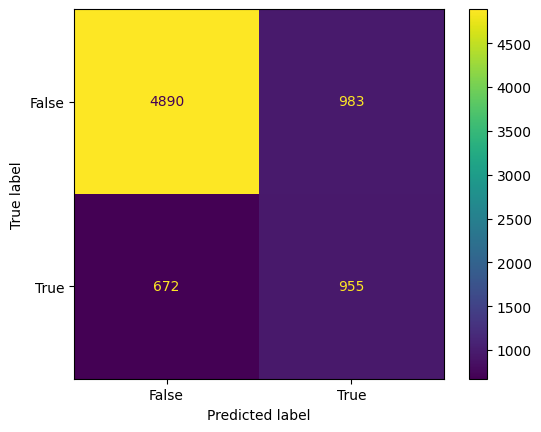

In [15]:
evaluate_model(cnn_model, X_test, y_test)

### SHAP

In [16]:
import shap


# Fits the explainer
explainer = shap.Explainer(cnn_model.predict, X_test[:1000], progress_bar="notebook", verbose= False)

C:\Installed_programs\Conda\envs\dc2\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test[:1000])

81/81 [==============================] - 0s 572us/step


Permutation explainer:   0%|▎                                                                 | 4/1000 [00:00<?, ?it/s]

78/78 [==============================] - 0s 569us/step


Permutation explainer:   1%|▎                                                         | 6/1000 [00:14<20:06,  1.21s/it]

81/81 [==============================] - 0s 600us/step


Permutation explainer:   1%|▍                                                         | 7/1000 [00:17<28:37,  1.73s/it]

79/79 [==============================] - 0s 562us/step


Permutation explainer:   1%|▍                                                         | 8/1000 [00:19<32:53,  1.99s/it]

77/77 [==============================] - 0s 582us/step


Permutation explainer:   1%|▌                                                         | 9/1000 [00:21<35:16,  2.14s/it]

85/85 [==============================] - 0s 656us/step


Permutation explainer:   1%|▌                                                        | 10/1000 [00:24<37:42,  2.29s/it]

74/74 [==============================] - 0s 577us/step


Permutation explainer:   1%|▋                                                        | 11/1000 [00:26<38:17,  2.32s/it]

87/87 [==============================] - 0s 598us/step


Permutation explainer:   1%|▋                                                        | 12/1000 [00:29<39:49,  2.42s/it]

86/86 [==============================] - 0s 579us/step


Permutation explainer:   1%|▋                                                        | 13/1000 [00:32<40:20,  2.45s/it]

82/82 [==============================] - 0s 577us/step


Permutation explainer:   1%|▊                                                        | 14/1000 [00:34<40:26,  2.46s/it]

83/83 [==============================] - 0s 583us/step


Permutation explainer:   2%|▊                                                        | 15/1000 [00:37<40:44,  2.48s/it]

86/86 [==============================] - 0s 599us/step


Permutation explainer:   2%|▉                                                        | 16/1000 [00:39<41:05,  2.51s/it]

77/77 [==============================] - 0s 587us/step


Permutation explainer:   2%|▉                                                        | 17/1000 [00:42<40:34,  2.48s/it]

81/81 [==============================] - 0s 585us/step


Permutation explainer:   2%|█                                                        | 18/1000 [00:44<40:23,  2.47s/it]

79/79 [==============================] - 0s 571us/step


Permutation explainer:   2%|█                                                        | 19/1000 [00:46<40:17,  2.46s/it]

83/83 [==============================] - 0s 576us/step


Permutation explainer:   2%|█▏                                                       | 20/1000 [00:49<40:32,  2.48s/it]

83/83 [==============================] - 0s 572us/step


Permutation explainer:   2%|█▏                                                       | 21/1000 [00:51<40:48,  2.50s/it]

78/78 [==============================] - 0s 577us/step


Permutation explainer:   2%|█▎                                                       | 22/1000 [00:54<40:12,  2.47s/it]

85/85 [==============================] - 0s 577us/step


Permutation explainer:   2%|█▎                                                       | 23/1000 [00:56<40:12,  2.47s/it]

78/78 [==============================] - 0s 592us/step


Permutation explainer:   2%|█▎                                                       | 24/1000 [00:59<39:47,  2.45s/it]

82/82 [==============================] - 0s 587us/step


Permutation explainer:   2%|█▍                                                       | 25/1000 [01:01<39:37,  2.44s/it]

81/81 [==============================] - 0s 609us/step


Permutation explainer:   3%|█▍                                                       | 26/1000 [01:04<39:44,  2.45s/it]

82/82 [==============================] - 0s 601us/step


Permutation explainer:   3%|█▌                                                       | 27/1000 [01:06<40:02,  2.47s/it]

85/85 [==============================] - 0s 557us/step


Permutation explainer:   3%|█▌                                                       | 28/1000 [01:08<39:08,  2.42s/it]

86/86 [==============================] - 0s 600us/step


Permutation explainer:   3%|█▋                                                       | 29/1000 [01:11<39:51,  2.46s/it]

82/82 [==============================] - 0s 590us/step


Permutation explainer:   3%|█▋                                                       | 30/1000 [01:13<39:56,  2.47s/it]

86/86 [==============================] - 0s 581us/step


Permutation explainer:   3%|█▊                                                       | 31/1000 [01:16<40:19,  2.50s/it]

83/83 [==============================] - 0s 593us/step


Permutation explainer:   3%|█▊                                                       | 32/1000 [01:19<40:25,  2.51s/it]

83/83 [==============================] - 0s 569us/step


Permutation explainer:   3%|█▉                                                       | 33/1000 [01:21<40:22,  2.50s/it]

85/85 [==============================] - 0s 595us/step


Permutation explainer:   3%|█▉                                                       | 34/1000 [01:24<40:16,  2.50s/it]

81/81 [==============================] - 0s 637us/step


Permutation explainer:   4%|█▉                                                       | 35/1000 [01:26<40:00,  2.49s/it]

82/82 [==============================] - 0s 645us/step


Permutation explainer:   4%|██                                                       | 36/1000 [01:28<39:45,  2.47s/it]

77/77 [==============================] - 0s 623us/step


Permutation explainer:   4%|██                                                       | 37/1000 [01:31<39:21,  2.45s/it]

84/84 [==============================] - 0s 572us/step


Permutation explainer:   4%|██▏                                                      | 38/1000 [01:33<39:15,  2.45s/it]

86/86 [==============================] - 0s 566us/step


Permutation explainer:   4%|██▏                                                      | 39/1000 [01:36<39:46,  2.48s/it]

79/79 [==============================] - 0s 598us/step


Permutation explainer:   4%|██▎                                                      | 40/1000 [01:38<39:41,  2.48s/it]

81/81 [==============================] - 0s 563us/step


Permutation explainer:   4%|██▎                                                      | 41/1000 [01:41<39:34,  2.48s/it]

80/80 [==============================] - 0s 576us/step


Permutation explainer:   4%|██▍                                                      | 42/1000 [01:43<39:20,  2.46s/it]

85/85 [==============================] - 0s 602us/step


Permutation explainer:   4%|██▍                                                      | 43/1000 [01:46<39:34,  2.48s/it]

77/77 [==============================] - 0s 597us/step


Permutation explainer:   4%|██▌                                                      | 44/1000 [01:48<39:18,  2.47s/it]

82/82 [==============================] - 0s 582us/step


Permutation explainer:   4%|██▌                                                      | 45/1000 [01:51<39:07,  2.46s/it]

81/81 [==============================] - 0s 581us/step


Permutation explainer:   5%|██▌                                                      | 46/1000 [01:53<39:23,  2.48s/it]

83/83 [==============================] - 0s 596us/step


Permutation explainer:   5%|██▋                                                      | 47/1000 [01:56<39:13,  2.47s/it]

85/85 [==============================] - 0s 583us/step


Permutation explainer:   5%|██▋                                                      | 48/1000 [01:58<39:34,  2.49s/it]

79/79 [==============================] - 0s 598us/step


Permutation explainer:   5%|██▊                                                      | 49/1000 [02:01<39:11,  2.47s/it]

79/79 [==============================] - 0s 577us/step


Permutation explainer:   5%|██▊                                                      | 50/1000 [02:03<39:02,  2.47s/it]

78/78 [==============================] - 0s 594us/step


Permutation explainer:   5%|██▉                                                      | 51/1000 [02:05<38:46,  2.45s/it]

78/78 [==============================] - 0s 587us/step


Permutation explainer:   5%|██▉                                                      | 52/1000 [02:08<38:35,  2.44s/it]

81/81 [==============================] - 0s 565us/step


Permutation explainer:   5%|███                                                      | 53/1000 [02:10<38:55,  2.47s/it]

79/79 [==============================] - 0s 579us/step


Permutation explainer:   5%|███                                                      | 54/1000 [02:13<38:43,  2.46s/it]

80/80 [==============================] - 0s 584us/step


Permutation explainer:   6%|███▏                                                     | 55/1000 [02:15<38:39,  2.45s/it]

85/85 [==============================] - 0s 609us/step


Permutation explainer:   6%|███▏                                                     | 56/1000 [02:18<38:59,  2.48s/it]

86/86 [==============================] - 0s 577us/step


Permutation explainer:   6%|███▏                                                     | 57/1000 [02:20<39:21,  2.50s/it]

79/79 [==============================] - 0s 568us/step


Permutation explainer:   6%|███▎                                                     | 58/1000 [02:23<38:56,  2.48s/it]

84/84 [==============================] - 0s 586us/step


Permutation explainer:   6%|███▎                                                     | 59/1000 [02:25<39:06,  2.49s/it]

86/86 [==============================] - 0s 590us/step


Permutation explainer:   6%|███▍                                                     | 60/1000 [02:28<39:17,  2.51s/it]

77/77 [==============================] - 0s 586us/step


Permutation explainer:   6%|███▍                                                     | 61/1000 [02:30<38:58,  2.49s/it]

85/85 [==============================] - 0s 574us/step


Permutation explainer:   6%|███▌                                                     | 62/1000 [02:33<39:07,  2.50s/it]

87/87 [==============================] - 0s 589us/step


Permutation explainer:   6%|███▌                                                     | 63/1000 [02:35<39:21,  2.52s/it]

84/84 [==============================] - 0s 574us/step


Permutation explainer:   6%|███▋                                                     | 64/1000 [02:38<38:59,  2.50s/it]

83/83 [==============================] - 0s 575us/step


Permutation explainer:   6%|███▋                                                     | 65/1000 [02:40<39:05,  2.51s/it]

82/82 [==============================] - 0s 582us/step


Permutation explainer:   7%|███▊                                                     | 66/1000 [02:43<38:53,  2.50s/it]

83/83 [==============================] - 0s 592us/step


Permutation explainer:   7%|███▊                                                     | 67/1000 [02:45<39:00,  2.51s/it]

82/82 [==============================] - 0s 607us/step


Permutation explainer:   7%|███▉                                                     | 68/1000 [02:48<38:46,  2.50s/it]

84/84 [==============================] - 0s 657us/step


Permutation explainer:   7%|███▉                                                     | 69/1000 [02:50<38:57,  2.51s/it]

78/78 [==============================] - 0s 604us/step


Permutation explainer:   7%|███▉                                                     | 70/1000 [02:53<38:15,  2.47s/it]

81/81 [==============================] - 0s 570us/step


Permutation explainer:   7%|████                                                     | 71/1000 [02:55<38:07,  2.46s/it]

77/77 [==============================] - 0s 568us/step


Permutation explainer:   7%|████                                                     | 72/1000 [02:58<37:57,  2.45s/it]

81/81 [==============================] - 0s 574us/step


Permutation explainer:   7%|████▏                                                    | 73/1000 [03:00<38:02,  2.46s/it]

80/80 [==============================] - 0s 564us/step


Permutation explainer:   7%|████▏                                                    | 74/1000 [03:03<37:52,  2.45s/it]

83/83 [==============================] - 0s 588us/step


Permutation explainer:   8%|████▎                                                    | 75/1000 [03:05<37:43,  2.45s/it]

82/82 [==============================] - 0s 562us/step


Permutation explainer:   8%|████▎                                                    | 76/1000 [03:07<37:38,  2.44s/it]

83/83 [==============================] - 0s 591us/step


Permutation explainer:   8%|████▍                                                    | 77/1000 [03:10<37:40,  2.45s/it]

82/82 [==============================] - 0s 585us/step


Permutation explainer:   8%|████▍                                                    | 78/1000 [03:12<37:35,  2.45s/it]

84/84 [==============================] - 0s 590us/step


Permutation explainer:   8%|████▌                                                    | 79/1000 [03:15<38:00,  2.48s/it]

83/83 [==============================] - 0s 666us/step


Permutation explainer:   8%|████▌                                                    | 80/1000 [03:17<38:12,  2.49s/it]

80/80 [==============================] - 0s 579us/step


Permutation explainer:   8%|████▌                                                    | 81/1000 [03:20<37:57,  2.48s/it]

85/85 [==============================] - 0s 591us/step


Permutation explainer:   8%|████▋                                                    | 82/1000 [03:22<38:10,  2.49s/it]

79/79 [==============================] - 0s 603us/step


Permutation explainer:   8%|████▋                                                    | 83/1000 [03:25<37:51,  2.48s/it]

78/78 [==============================] - 0s 564us/step


Permutation explainer:   8%|████▊                                                    | 84/1000 [03:27<37:29,  2.46s/it]

83/83 [==============================] - 0s 605us/step


Permutation explainer:   8%|████▊                                                    | 85/1000 [03:30<37:35,  2.47s/it]

84/84 [==============================] - 0s 578us/step


Permutation explainer:   9%|████▉                                                    | 86/1000 [03:32<37:52,  2.49s/it]

83/83 [==============================] - 0s 583us/step


Permutation explainer:   9%|████▉                                                    | 87/1000 [03:35<37:51,  2.49s/it]

84/84 [==============================] - 0s 571us/step


Permutation explainer:   9%|█████                                                    | 88/1000 [03:37<38:01,  2.50s/it]

81/81 [==============================] - 0s 558us/step


Permutation explainer:   9%|█████                                                    | 89/1000 [03:40<37:41,  2.48s/it]

82/82 [==============================] - 0s 603us/step


Permutation explainer:   9%|█████▏                                                   | 90/1000 [03:42<37:29,  2.47s/it]

78/78 [==============================] - 0s 593us/step


Permutation explainer:   9%|█████▏                                                   | 91/1000 [03:45<37:02,  2.44s/it]

83/83 [==============================] - 0s 562us/step


Permutation explainer:   9%|█████▏                                                   | 92/1000 [03:47<37:09,  2.46s/it]

80/80 [==============================] - 0s 586us/step


Permutation explainer:   9%|█████▎                                                   | 93/1000 [03:49<37:07,  2.46s/it]

85/85 [==============================] - 0s 586us/step


Permutation explainer:   9%|█████▎                                                   | 94/1000 [03:52<37:13,  2.47s/it]

80/80 [==============================] - 0s 582us/step


Permutation explainer:  10%|█████▍                                                   | 95/1000 [03:54<37:10,  2.47s/it]

86/86 [==============================] - 0s 578us/step


Permutation explainer:  10%|█████▍                                                   | 96/1000 [03:57<37:11,  2.47s/it]

81/81 [==============================] - 0s 583us/step


Permutation explainer:  10%|█████▌                                                   | 97/1000 [03:59<36:57,  2.46s/it]

80/80 [==============================] - 0s 676us/step


Permutation explainer:  10%|█████▌                                                   | 98/1000 [04:02<36:49,  2.45s/it]

81/81 [==============================] - 0s 577us/step


Permutation explainer:  10%|█████▋                                                   | 99/1000 [04:04<37:01,  2.47s/it]

77/77 [==============================] - 0s 574us/step


Permutation explainer:  10%|█████▌                                                  | 100/1000 [04:07<36:42,  2.45s/it]

83/83 [==============================] - 0s 648us/step


Permutation explainer:  10%|█████▋                                                  | 101/1000 [04:09<36:51,  2.46s/it]

86/86 [==============================] - 0s 576us/step


Permutation explainer:  10%|█████▋                                                  | 102/1000 [04:11<35:49,  2.39s/it]

81/81 [==============================] - 0s 568us/step


Permutation explainer:  10%|█████▊                                                  | 103/1000 [04:14<36:06,  2.42s/it]

80/80 [==============================] - 0s 573us/step


Permutation explainer:  10%|█████▊                                                  | 104/1000 [04:16<36:09,  2.42s/it]

85/85 [==============================] - 0s 572us/step


Permutation explainer:  10%|█████▉                                                  | 105/1000 [04:19<36:30,  2.45s/it]

82/82 [==============================] - 0s 593us/step


Permutation explainer:  11%|█████▉                                                  | 106/1000 [04:21<36:35,  2.46s/it]

78/78 [==============================] - 0s 591us/step


Permutation explainer:  11%|█████▉                                                  | 107/1000 [04:24<36:29,  2.45s/it]

83/83 [==============================] - 0s 574us/step


Permutation explainer:  11%|██████                                                  | 108/1000 [04:26<36:31,  2.46s/it]

83/83 [==============================] - 0s 581us/step


Permutation explainer:  11%|██████                                                  | 109/1000 [04:29<36:20,  2.45s/it]

83/83 [==============================] - 0s 585us/step


Permutation explainer:  11%|██████▏                                                 | 110/1000 [04:31<36:28,  2.46s/it]

79/79 [==============================] - 0s 558us/step


Permutation explainer:  11%|██████▏                                                 | 111/1000 [04:34<36:19,  2.45s/it]

85/85 [==============================] - 0s 624us/step


Permutation explainer:  11%|██████▎                                                 | 112/1000 [04:36<36:39,  2.48s/it]

80/80 [==============================] - 0s 589us/step


Permutation explainer:  11%|██████▎                                                 | 113/1000 [04:39<36:22,  2.46s/it]

79/79 [==============================] - 0s 605us/step


Permutation explainer:  11%|██████▍                                                 | 114/1000 [04:41<36:15,  2.46s/it]

85/85 [==============================] - 0s 667us/step


Permutation explainer:  12%|██████▍                                                 | 115/1000 [04:44<36:53,  2.50s/it]

80/80 [==============================] - 0s 577us/step


Permutation explainer:  12%|██████▍                                                 | 116/1000 [04:46<36:44,  2.49s/it]

83/83 [==============================] - 0s 580us/step


Permutation explainer:  12%|██████▌                                                 | 117/1000 [04:49<36:37,  2.49s/it]

83/83 [==============================] - 0s 584us/step


Permutation explainer:  12%|██████▌                                                 | 118/1000 [04:51<36:48,  2.50s/it]

82/82 [==============================] - 0s 562us/step


Permutation explainer:  12%|██████▋                                                 | 119/1000 [04:54<36:42,  2.50s/it]

82/82 [==============================] - 0s 565us/step


Permutation explainer:  12%|██████▋                                                 | 120/1000 [04:56<36:32,  2.49s/it]

83/83 [==============================] - 0s 588us/step


Permutation explainer:  12%|██████▊                                                 | 121/1000 [04:59<36:24,  2.48s/it]

87/87 [==============================] - 0s 574us/step


Permutation explainer:  12%|██████▊                                                 | 122/1000 [05:01<35:27,  2.42s/it]

82/82 [==============================] - 0s 591us/step


Permutation explainer:  12%|██████▉                                                 | 123/1000 [05:03<35:38,  2.44s/it]

76/76 [==============================] - 0s 607us/step


Permutation explainer:  12%|██████▉                                                 | 124/1000 [05:06<35:46,  2.45s/it]

82/82 [==============================] - 0s 661us/step


Permutation explainer:  12%|███████                                                 | 125/1000 [05:08<35:54,  2.46s/it]

81/81 [==============================] - 0s 657us/step


Permutation explainer:  13%|███████                                                 | 126/1000 [05:11<35:44,  2.45s/it]

79/79 [==============================] - 0s 635us/step


Permutation explainer:  13%|███████                                                 | 127/1000 [05:13<35:41,  2.45s/it]

80/80 [==============================] - 0s 580us/step


Permutation explainer:  13%|███████▏                                                | 128/1000 [05:16<35:39,  2.45s/it]

80/80 [==============================] - 0s 581us/step


Permutation explainer:  13%|███████▏                                                | 129/1000 [05:18<35:36,  2.45s/it]

78/78 [==============================] - 0s 596us/step


Permutation explainer:  13%|███████▎                                                | 130/1000 [05:20<35:39,  2.46s/it]

80/80 [==============================] - 0s 565us/step


Permutation explainer:  13%|███████▎                                                | 131/1000 [05:23<35:25,  2.45s/it]

81/81 [==============================] - 0s 574us/step


Permutation explainer:  13%|███████▍                                                | 132/1000 [05:25<35:27,  2.45s/it]

78/78 [==============================] - 0s 584us/step


Permutation explainer:  13%|███████▍                                                | 133/1000 [05:28<35:20,  2.45s/it]

81/81 [==============================] - 0s 594us/step


Permutation explainer:  13%|███████▌                                                | 134/1000 [05:30<35:21,  2.45s/it]

83/83 [==============================] - 0s 555us/step


Permutation explainer:  14%|███████▌                                                | 135/1000 [05:33<35:11,  2.44s/it]

82/82 [==============================] - 0s 603us/step


Permutation explainer:  14%|███████▌                                                | 136/1000 [05:35<35:11,  2.44s/it]

79/79 [==============================] - 0s 601us/step


Permutation explainer:  14%|███████▋                                                | 137/1000 [05:38<35:07,  2.44s/it]

83/83 [==============================] - 0s 570us/step


Permutation explainer:  14%|███████▋                                                | 138/1000 [05:40<35:24,  2.46s/it]

80/80 [==============================] - 0s 587us/step


Permutation explainer:  14%|███████▊                                                | 139/1000 [05:43<35:18,  2.46s/it]

82/82 [==============================] - 0s 586us/step


Permutation explainer:  14%|███████▊                                                | 140/1000 [05:45<35:19,  2.46s/it]

81/81 [==============================] - 0s 589us/step


Permutation explainer:  14%|███████▉                                                | 141/1000 [05:47<35:17,  2.46s/it]

81/81 [==============================] - 0s 572us/step


Permutation explainer:  14%|███████▉                                                | 142/1000 [05:50<35:02,  2.45s/it]

82/82 [==============================] - 0s 567us/step


Permutation explainer:  14%|████████                                                | 143/1000 [05:52<35:14,  2.47s/it]

87/87 [==============================] - 0s 639us/step


Permutation explainer:  14%|████████                                                | 144/1000 [05:55<34:28,  2.42s/it]

84/84 [==============================] - 0s 612us/step


Permutation explainer:  14%|████████                                                | 145/1000 [05:57<36:00,  2.53s/it]

83/83 [==============================] - 0s 631us/step


Permutation explainer:  15%|████████▏                                               | 146/1000 [06:00<36:22,  2.56s/it]

85/85 [==============================] - 0s 661us/step


Permutation explainer:  15%|████████▏                                               | 147/1000 [06:03<36:21,  2.56s/it]

83/83 [==============================] - 0s 608us/step


Permutation explainer:  15%|████████▎                                               | 148/1000 [06:05<36:16,  2.55s/it]

76/76 [==============================] - 0s 588us/step


Permutation explainer:  15%|████████▎                                               | 149/1000 [06:08<35:50,  2.53s/it]

79/79 [==============================] - 0s 578us/step


Permutation explainer:  15%|████████▍                                               | 150/1000 [06:10<35:33,  2.51s/it]

80/80 [==============================] - 0s 601us/step


Permutation explainer:  15%|████████▍                                               | 151/1000 [06:13<35:18,  2.50s/it]

77/77 [==============================] - 0s 598us/step


Permutation explainer:  15%|████████▌                                               | 152/1000 [06:15<35:05,  2.48s/it]

77/77 [==============================] - 0s 580us/step


Permutation explainer:  15%|████████▌                                               | 153/1000 [06:18<34:56,  2.48s/it]

81/81 [==============================] - 0s 599us/step


Permutation explainer:  15%|████████▌                                               | 154/1000 [06:20<34:58,  2.48s/it]

85/85 [==============================] - 0s 612us/step


Permutation explainer:  16%|████████▋                                               | 155/1000 [06:23<35:15,  2.50s/it]

84/84 [==============================] - 0s 605us/step


Permutation explainer:  16%|████████▋                                               | 156/1000 [06:25<35:17,  2.51s/it]

80/80 [==============================] - 0s 598us/step


Permutation explainer:  16%|████████▊                                               | 157/1000 [06:28<35:00,  2.49s/it]

85/85 [==============================] - 0s 577us/step


Permutation explainer:  16%|████████▊                                               | 158/1000 [06:30<35:18,  2.52s/it]

82/82 [==============================] - 0s 608us/step


Permutation explainer:  16%|████████▉                                               | 159/1000 [06:33<35:20,  2.52s/it]

84/84 [==============================] - 0s 593us/step


Permutation explainer:  16%|████████▉                                               | 160/1000 [06:35<35:21,  2.53s/it]

81/81 [==============================] - 0s 586us/step


Permutation explainer:  16%|█████████                                               | 161/1000 [06:38<35:18,  2.52s/it]

84/84 [==============================] - 0s 579us/step


Permutation explainer:  16%|█████████                                               | 162/1000 [06:40<35:08,  2.52s/it]

82/82 [==============================] - 0s 593us/step


Permutation explainer:  16%|█████████▏                                              | 163/1000 [06:43<34:56,  2.50s/it]

84/84 [==============================] - 0s 614us/step


Permutation explainer:  16%|█████████▏                                              | 164/1000 [06:45<34:47,  2.50s/it]

83/83 [==============================] - 0s 619us/step


Permutation explainer:  16%|█████████▏                                              | 165/1000 [06:48<34:38,  2.49s/it]

80/80 [==============================] - 0s 576us/step


Permutation explainer:  17%|█████████▎                                              | 166/1000 [06:50<34:29,  2.48s/it]

84/84 [==============================] - 0s 589us/step


Permutation explainer:  17%|█████████▎                                              | 167/1000 [06:53<34:34,  2.49s/it]

77/77 [==============================] - 0s 585us/step


Permutation explainer:  17%|█████████▍                                              | 168/1000 [06:55<34:14,  2.47s/it]

83/83 [==============================] - 0s 592us/step


Permutation explainer:  17%|█████████▍                                              | 169/1000 [06:57<34:11,  2.47s/it]

82/82 [==============================] - 0s 565us/step


Permutation explainer:  17%|█████████▌                                              | 170/1000 [07:00<34:23,  2.49s/it]

83/83 [==============================] - 0s 584us/step


Permutation explainer:  17%|█████████▌                                              | 171/1000 [07:03<34:25,  2.49s/it]

84/84 [==============================] - 0s 568us/step


Permutation explainer:  17%|█████████▋                                              | 172/1000 [07:05<34:36,  2.51s/it]

80/80 [==============================] - 0s 571us/step


Permutation explainer:  17%|█████████▋                                              | 173/1000 [07:08<34:20,  2.49s/it]

80/80 [==============================] - 0s 582us/step


Permutation explainer:  17%|█████████▋                                              | 174/1000 [07:10<34:10,  2.48s/it]

78/78 [==============================] - 0s 588us/step


Permutation explainer:  18%|█████████▊                                              | 175/1000 [07:12<33:50,  2.46s/it]

79/79 [==============================] - 0s 646us/step


Permutation explainer:  18%|█████████▊                                              | 176/1000 [07:15<33:47,  2.46s/it]

78/78 [==============================] - 0s 578us/step


Permutation explainer:  18%|█████████▉                                              | 177/1000 [07:17<33:28,  2.44s/it]

83/83 [==============================] - 0s 581us/step


Permutation explainer:  18%|█████████▉                                              | 178/1000 [07:20<33:49,  2.47s/it]

83/83 [==============================] - 0s 610us/step


Permutation explainer:  18%|██████████                                              | 179/1000 [07:22<33:58,  2.48s/it]

82/82 [==============================] - 0s 582us/step


Permutation explainer:  18%|██████████                                              | 180/1000 [07:25<33:53,  2.48s/it]

81/81 [==============================] - 0s 588us/step


Permutation explainer:  18%|██████████▏                                             | 181/1000 [07:27<33:50,  2.48s/it]

83/83 [==============================] - 0s 578us/step


Permutation explainer:  18%|██████████▏                                             | 182/1000 [07:30<33:51,  2.48s/it]

82/82 [==============================] - 0s 577us/step


Permutation explainer:  18%|██████████▏                                             | 183/1000 [07:32<33:50,  2.49s/it]

82/82 [==============================] - 0s 570us/step


Permutation explainer:  18%|██████████▎                                             | 184/1000 [07:35<33:32,  2.47s/it]

82/82 [==============================] - 0s 588us/step


Permutation explainer:  18%|██████████▎                                             | 185/1000 [07:37<33:41,  2.48s/it]

83/83 [==============================] - 0s 574us/step


Permutation explainer:  19%|██████████▍                                             | 186/1000 [07:40<33:43,  2.49s/it]

84/84 [==============================] - 0s 591us/step


Permutation explainer:  19%|██████████▍                                             | 187/1000 [07:42<33:37,  2.48s/it]

83/83 [==============================] - 0s 575us/step


Permutation explainer:  19%|██████████▌                                             | 188/1000 [07:45<33:36,  2.48s/it]

83/83 [==============================] - 0s 580us/step


Permutation explainer:  19%|██████████▌                                             | 189/1000 [07:47<33:22,  2.47s/it]

80/80 [==============================] - 0s 610us/step


Permutation explainer:  19%|██████████▋                                             | 190/1000 [07:49<33:07,  2.45s/it]

79/79 [==============================] - 0s 582us/step


Permutation explainer:  19%|██████████▋                                             | 191/1000 [07:52<33:08,  2.46s/it]

83/83 [==============================] - 0s 574us/step


Permutation explainer:  19%|██████████▊                                             | 192/1000 [07:54<33:08,  2.46s/it]

84/84 [==============================] - 0s 578us/step


Permutation explainer:  19%|██████████▊                                             | 193/1000 [07:57<33:10,  2.47s/it]

78/78 [==============================] - 0s 563us/step


Permutation explainer:  19%|██████████▊                                             | 194/1000 [07:59<32:51,  2.45s/it]

75/75 [==============================] - 0s 609us/step


Permutation explainer:  20%|██████████▉                                             | 195/1000 [08:02<32:47,  2.44s/it]

82/82 [==============================] - 0s 664us/step


Permutation explainer:  20%|██████████▉                                             | 196/1000 [08:04<33:07,  2.47s/it]

83/83 [==============================] - 0s 586us/step


Permutation explainer:  20%|███████████                                             | 197/1000 [08:07<33:16,  2.49s/it]

80/80 [==============================] - 0s 579us/step


Permutation explainer:  20%|███████████                                             | 198/1000 [08:09<33:13,  2.49s/it]

81/81 [==============================] - 0s 592us/step


Permutation explainer:  20%|███████████▏                                            | 199/1000 [08:12<32:54,  2.46s/it]

80/80 [==============================] - 0s 589us/step


Permutation explainer:  20%|███████████▏                                            | 200/1000 [08:14<32:45,  2.46s/it]

85/85 [==============================] - 0s 585us/step


Permutation explainer:  20%|███████████▎                                            | 201/1000 [08:17<32:57,  2.47s/it]

83/83 [==============================] - 0s 586us/step


Permutation explainer:  20%|███████████▎                                            | 202/1000 [08:19<32:43,  2.46s/it]

84/84 [==============================] - 0s 607us/step


Permutation explainer:  20%|███████████▎                                            | 203/1000 [08:22<32:53,  2.48s/it]

85/85 [==============================] - 0s 583us/step


Permutation explainer:  20%|███████████▍                                            | 204/1000 [08:24<31:50,  2.40s/it]

87/87 [==============================] - 0s 586us/step


Permutation explainer:  20%|███████████▍                                            | 205/1000 [08:26<32:17,  2.44s/it]

80/80 [==============================] - 0s 600us/step


Permutation explainer:  21%|███████████▌                                            | 206/1000 [08:29<32:16,  2.44s/it]

86/86 [==============================] - 0s 572us/step


Permutation explainer:  21%|███████████▌                                            | 207/1000 [08:31<32:54,  2.49s/it]

83/83 [==============================] - 0s 571us/step


Permutation explainer:  21%|███████████▋                                            | 208/1000 [08:34<32:49,  2.49s/it]

82/82 [==============================] - 0s 596us/step


Permutation explainer:  21%|███████████▋                                            | 209/1000 [08:36<32:38,  2.48s/it]

80/80 [==============================] - 0s 585us/step


Permutation explainer:  21%|███████████▊                                            | 210/1000 [08:39<32:33,  2.47s/it]

80/80 [==============================] - 0s 594us/step


Permutation explainer:  21%|███████████▊                                            | 211/1000 [08:41<32:25,  2.47s/it]

77/77 [==============================] - 0s 562us/step


Permutation explainer:  21%|███████████▊                                            | 212/1000 [08:44<32:13,  2.45s/it]

83/83 [==============================] - 0s 570us/step


Permutation explainer:  21%|███████████▉                                            | 213/1000 [08:46<32:26,  2.47s/it]

82/82 [==============================] - 0s 602us/step


Permutation explainer:  21%|███████████▉                                            | 214/1000 [08:49<32:30,  2.48s/it]

84/84 [==============================] - 0s 613us/step


Permutation explainer:  22%|████████████                                            | 215/1000 [08:51<32:31,  2.49s/it]

85/85 [==============================] - 0s 588us/step


Permutation explainer:  22%|████████████                                            | 216/1000 [08:54<32:48,  2.51s/it]

82/82 [==============================] - 0s 575us/step


Permutation explainer:  22%|████████████▏                                           | 217/1000 [08:56<32:56,  2.52s/it]

78/78 [==============================] - 0s 600us/step


Permutation explainer:  22%|████████████▏                                           | 218/1000 [08:59<32:31,  2.50s/it]

83/83 [==============================] - 0s 654us/step


Permutation explainer:  22%|████████████▎                                           | 219/1000 [09:01<32:41,  2.51s/it]

79/79 [==============================] - 0s 575us/step


Permutation explainer:  22%|████████████▎                                           | 220/1000 [09:04<32:27,  2.50s/it]

83/83 [==============================] - 0s 605us/step


Permutation explainer:  22%|████████████▍                                           | 221/1000 [09:06<32:14,  2.48s/it]

83/83 [==============================] - 0s 574us/step


Permutation explainer:  22%|████████████▍                                           | 222/1000 [09:09<32:11,  2.48s/it]

83/83 [==============================] - 0s 581us/step


Permutation explainer:  22%|████████████▍                                           | 223/1000 [09:11<32:08,  2.48s/it]

82/82 [==============================] - 0s 580us/step


Permutation explainer:  22%|████████████▌                                           | 224/1000 [09:14<32:01,  2.48s/it]

79/79 [==============================] - 0s 566us/step


Permutation explainer:  22%|████████████▌                                           | 225/1000 [09:16<31:51,  2.47s/it]

76/76 [==============================] - 0s 580us/step


Permutation explainer:  23%|████████████▋                                           | 226/1000 [09:18<31:33,  2.45s/it]

84/84 [==============================] - 0s 581us/step


Permutation explainer:  23%|████████████▋                                           | 227/1000 [09:21<31:54,  2.48s/it]

83/83 [==============================] - 0s 582us/step


Permutation explainer:  23%|████████████▊                                           | 228/1000 [09:24<32:06,  2.50s/it]

82/82 [==============================] - 0s 581us/step


Permutation explainer:  23%|████████████▊                                           | 229/1000 [09:26<31:59,  2.49s/it]

82/82 [==============================] - 0s 583us/step


Permutation explainer:  23%|████████████▉                                           | 230/1000 [09:28<31:07,  2.43s/it]

84/84 [==============================] - 0s 581us/step


Permutation explainer:  23%|████████████▉                                           | 231/1000 [09:31<31:31,  2.46s/it]

86/86 [==============================] - 0s 580us/step


Permutation explainer:  23%|████████████▉                                           | 232/1000 [09:33<31:45,  2.48s/it]

84/84 [==============================] - 0s 592us/step


Permutation explainer:  23%|█████████████                                           | 233/1000 [09:36<31:45,  2.48s/it]

81/81 [==============================] - 0s 591us/step


Permutation explainer:  23%|█████████████                                           | 234/1000 [09:38<31:41,  2.48s/it]

84/84 [==============================] - 0s 615us/step


Permutation explainer:  24%|█████████████▏                                          | 235/1000 [09:41<31:44,  2.49s/it]

84/84 [==============================] - 0s 586us/step


Permutation explainer:  24%|█████████████▏                                          | 236/1000 [09:43<31:47,  2.50s/it]

83/83 [==============================] - 0s 587us/step


Permutation explainer:  24%|█████████████▎                                          | 237/1000 [09:46<31:48,  2.50s/it]

79/79 [==============================] - 0s 598us/step


Permutation explainer:  24%|█████████████▎                                          | 238/1000 [09:48<31:27,  2.48s/it]

81/81 [==============================] - 0s 564us/step


Permutation explainer:  24%|█████████████▍                                          | 239/1000 [09:51<31:18,  2.47s/it]

77/77 [==============================] - 0s 596us/step


Permutation explainer:  24%|█████████████▍                                          | 240/1000 [09:53<30:55,  2.44s/it]

85/85 [==============================] - 0s 575us/step


Permutation explainer:  24%|█████████████▍                                          | 241/1000 [09:56<31:31,  2.49s/it]

79/79 [==============================] - 0s 579us/step


Permutation explainer:  24%|█████████████▌                                          | 242/1000 [09:58<31:58,  2.53s/it]

81/81 [==============================] - 0s 588us/step


Permutation explainer:  24%|█████████████▌                                          | 243/1000 [10:01<31:35,  2.50s/it]

83/83 [==============================] - 0s 579us/step


Permutation explainer:  24%|█████████████▋                                          | 244/1000 [10:03<31:30,  2.50s/it]

83/83 [==============================] - 0s 576us/step


Permutation explainer:  24%|█████████████▋                                          | 245/1000 [10:06<31:18,  2.49s/it]

86/86 [==============================] - 0s 559us/step


Permutation explainer:  25%|█████████████▊                                          | 246/1000 [10:08<31:27,  2.50s/it]

83/83 [==============================] - 0s 566us/step


Permutation explainer:  25%|█████████████▊                                          | 247/1000 [10:11<31:10,  2.48s/it]

81/81 [==============================] - 0s 597us/step


Permutation explainer:  25%|█████████████▉                                          | 248/1000 [10:13<30:56,  2.47s/it]

78/78 [==============================] - 0s 582us/step


Permutation explainer:  25%|█████████████▉                                          | 249/1000 [10:16<30:38,  2.45s/it]

82/82 [==============================] - 0s 579us/step


Permutation explainer:  25%|██████████████                                          | 250/1000 [10:18<30:48,  2.46s/it]

82/82 [==============================] - 0s 576us/step


Permutation explainer:  25%|██████████████                                          | 251/1000 [10:21<30:46,  2.47s/it]

84/84 [==============================] - 0s 595us/step


Permutation explainer:  25%|██████████████                                          | 252/1000 [10:23<30:54,  2.48s/it]

83/83 [==============================] - 0s 585us/step


Permutation explainer:  25%|██████████████▏                                         | 253/1000 [10:26<31:04,  2.50s/it]

86/86 [==============================] - 0s 569us/step


Permutation explainer:  25%|██████████████▏                                         | 254/1000 [10:28<31:12,  2.51s/it]

84/84 [==============================] - 0s 573us/step


Permutation explainer:  26%|██████████████▎                                         | 255/1000 [10:31<31:07,  2.51s/it]

83/83 [==============================] - 0s 574us/step


Permutation explainer:  26%|██████████████▎                                         | 256/1000 [10:33<31:04,  2.51s/it]

82/82 [==============================] - 0s 561us/step


Permutation explainer:  26%|██████████████▍                                         | 257/1000 [10:36<31:03,  2.51s/it]

77/77 [==============================] - 0s 589us/step


Permutation explainer:  26%|██████████████▍                                         | 258/1000 [10:38<30:43,  2.48s/it]

78/78 [==============================] - 0s 591us/step


Permutation explainer:  26%|██████████████▌                                         | 259/1000 [10:40<30:28,  2.47s/it]

85/85 [==============================] - 0s 584us/step


Permutation explainer:  26%|██████████████▌                                         | 260/1000 [10:43<30:37,  2.48s/it]

83/83 [==============================] - 0s 588us/step


Permutation explainer:  26%|██████████████▌                                         | 261/1000 [10:46<30:44,  2.50s/it]

84/84 [==============================] - 0s 592us/step


Permutation explainer:  26%|██████████████▋                                         | 262/1000 [10:48<31:00,  2.52s/it]

82/82 [==============================] - 0s 575us/step


Permutation explainer:  26%|██████████████▋                                         | 263/1000 [10:51<30:45,  2.50s/it]

83/83 [==============================] - 0s 594us/step


Permutation explainer:  26%|██████████████▊                                         | 264/1000 [10:53<30:31,  2.49s/it]

79/79 [==============================] - 0s 601us/step


Permutation explainer:  26%|██████████████▊                                         | 265/1000 [10:55<30:22,  2.48s/it]

79/79 [==============================] - 0s 574us/step


Permutation explainer:  27%|██████████████▉                                         | 266/1000 [10:58<30:04,  2.46s/it]

80/80 [==============================] - 0s 591us/step


Permutation explainer:  27%|██████████████▉                                         | 267/1000 [11:00<30:05,  2.46s/it]

83/83 [==============================] - 0s 572us/step


Permutation explainer:  27%|███████████████                                         | 268/1000 [11:03<30:03,  2.46s/it]

77/77 [==============================] - 0s 582us/step


Permutation explainer:  27%|███████████████                                         | 269/1000 [11:05<29:52,  2.45s/it]

80/80 [==============================] - 0s 588us/step


Permutation explainer:  27%|███████████████                                         | 270/1000 [11:08<29:52,  2.46s/it]

84/84 [==============================] - 0s 583us/step


Permutation explainer:  27%|███████████████▏                                        | 271/1000 [11:10<30:05,  2.48s/it]

77/77 [==============================] - 0s 573us/step


Permutation explainer:  27%|███████████████▏                                        | 272/1000 [11:13<29:49,  2.46s/it]

85/85 [==============================] - 0s 606us/step


Permutation explainer:  27%|███████████████▎                                        | 273/1000 [11:15<29:57,  2.47s/it]

78/78 [==============================] - 0s 587us/step


Permutation explainer:  27%|███████████████▎                                        | 274/1000 [11:18<29:42,  2.46s/it]

81/81 [==============================] - 0s 572us/step


Permutation explainer:  28%|███████████████▍                                        | 275/1000 [11:20<29:45,  2.46s/it]

85/85 [==============================] - 0s 611us/step


Permutation explainer:  28%|███████████████▍                                        | 276/1000 [11:23<29:54,  2.48s/it]

81/81 [==============================] - 0s 577us/step


Permutation explainer:  28%|███████████████▌                                        | 277/1000 [11:25<29:47,  2.47s/it]

82/82 [==============================] - 0s 602us/step


Permutation explainer:  28%|███████████████▌                                        | 278/1000 [11:27<29:39,  2.46s/it]

81/81 [==============================] - 0s 646us/step


Permutation explainer:  28%|███████████████▌                                        | 279/1000 [11:30<29:38,  2.47s/it]

79/79 [==============================] - 0s 587us/step


Permutation explainer:  28%|███████████████▋                                        | 280/1000 [11:32<29:30,  2.46s/it]

81/81 [==============================] - 0s 611us/step


Permutation explainer:  28%|███████████████▋                                        | 281/1000 [11:35<29:31,  2.46s/it]

83/83 [==============================] - 0s 581us/step


Permutation explainer:  28%|███████████████▊                                        | 282/1000 [11:37<29:31,  2.47s/it]

80/80 [==============================] - 0s 596us/step


Permutation explainer:  28%|███████████████▊                                        | 283/1000 [11:40<29:23,  2.46s/it]

84/84 [==============================] - 0s 597us/step


Permutation explainer:  28%|███████████████▉                                        | 284/1000 [11:42<29:32,  2.48s/it]

86/86 [==============================] - 0s 603us/step


Permutation explainer:  28%|███████████████▉                                        | 285/1000 [11:45<29:31,  2.48s/it]

80/80 [==============================] - 0s 581us/step


Permutation explainer:  29%|████████████████                                        | 286/1000 [11:47<29:25,  2.47s/it]

85/85 [==============================] - 0s 588us/step


Permutation explainer:  29%|████████████████                                        | 287/1000 [11:50<29:52,  2.51s/it]

80/80 [==============================] - 0s 589us/step


Permutation explainer:  29%|████████████████▏                                       | 288/1000 [11:52<29:30,  2.49s/it]

87/87 [==============================] - 0s 581us/step


Permutation explainer:  29%|████████████████▏                                       | 289/1000 [11:55<29:45,  2.51s/it]

83/83 [==============================] - 0s 577us/step


Permutation explainer:  29%|████████████████▏                                       | 290/1000 [11:57<29:56,  2.53s/it]

81/81 [==============================] - 0s 584us/step


Permutation explainer:  29%|████████████████▎                                       | 291/1000 [12:00<29:41,  2.51s/it]

81/81 [==============================] - 0s 607us/step


Permutation explainer:  29%|████████████████▎                                       | 292/1000 [12:02<29:28,  2.50s/it]

83/83 [==============================] - 0s 583us/step


Permutation explainer:  29%|████████████████▍                                       | 293/1000 [12:05<29:21,  2.49s/it]

81/81 [==============================] - 0s 553us/step


Permutation explainer:  29%|████████████████▍                                       | 294/1000 [12:07<29:28,  2.51s/it]

79/79 [==============================] - 0s 585us/step


Permutation explainer:  30%|████████████████▌                                       | 295/1000 [12:10<29:11,  2.48s/it]

86/86 [==============================] - 0s 603us/step


Permutation explainer:  30%|████████████████▌                                       | 296/1000 [12:12<29:23,  2.51s/it]

84/84 [==============================] - 0s 622us/step


Permutation explainer:  30%|████████████████▋                                       | 297/1000 [12:15<29:14,  2.50s/it]

84/84 [==============================] - 0s 578us/step


Permutation explainer:  30%|████████████████▋                                       | 298/1000 [12:17<29:07,  2.49s/it]

82/82 [==============================] - 0s 661us/step


Permutation explainer:  30%|████████████████▋                                       | 299/1000 [12:20<29:21,  2.51s/it]

82/82 [==============================] - 0s 615us/step


Permutation explainer:  30%|████████████████▊                                       | 300/1000 [12:22<29:09,  2.50s/it]

81/81 [==============================] - 0s 572us/step


Permutation explainer:  30%|████████████████▊                                       | 301/1000 [12:25<28:55,  2.48s/it]

84/84 [==============================] - 0s 583us/step


Permutation explainer:  30%|████████████████▉                                       | 302/1000 [12:27<29:09,  2.51s/it]

83/83 [==============================] - 0s 581us/step


Permutation explainer:  30%|████████████████▉                                       | 303/1000 [12:30<29:09,  2.51s/it]

80/80 [==============================] - 0s 584us/step


Permutation explainer:  30%|█████████████████                                       | 304/1000 [12:32<28:53,  2.49s/it]

80/80 [==============================] - 0s 605us/step


Permutation explainer:  30%|█████████████████                                       | 305/1000 [12:35<28:49,  2.49s/it]

81/81 [==============================] - 0s 590us/step


Permutation explainer:  31%|█████████████████▏                                      | 306/1000 [12:37<28:36,  2.47s/it]

80/80 [==============================] - 0s 577us/step


Permutation explainer:  31%|█████████████████▏                                      | 307/1000 [12:40<28:31,  2.47s/it]

81/81 [==============================] - 0s 588us/step


Permutation explainer:  31%|█████████████████▏                                      | 308/1000 [12:42<28:22,  2.46s/it]

84/84 [==============================] - 0s 570us/step


Permutation explainer:  31%|█████████████████▎                                      | 309/1000 [12:45<28:30,  2.48s/it]

80/80 [==============================] - 0s 583us/step


Permutation explainer:  31%|█████████████████▎                                      | 310/1000 [12:47<28:34,  2.48s/it]

82/82 [==============================] - 0s 680us/step


Permutation explainer:  31%|█████████████████▍                                      | 311/1000 [12:50<28:35,  2.49s/it]

85/85 [==============================] - 0s 586us/step


Permutation explainer:  31%|█████████████████▍                                      | 312/1000 [12:52<28:35,  2.49s/it]

82/82 [==============================] - 0s 676us/step


Permutation explainer:  31%|█████████████████▌                                      | 313/1000 [12:55<28:33,  2.49s/it]

79/79 [==============================] - 0s 590us/step


Permutation explainer:  31%|█████████████████▌                                      | 314/1000 [12:57<28:16,  2.47s/it]

84/84 [==============================] - 0s 575us/step


Permutation explainer:  32%|█████████████████▋                                      | 315/1000 [13:00<28:22,  2.48s/it]

81/81 [==============================] - 0s 583us/step


Permutation explainer:  32%|█████████████████▋                                      | 316/1000 [13:02<28:20,  2.49s/it]

83/83 [==============================] - 0s 589us/step


Permutation explainer:  32%|█████████████████▊                                      | 317/1000 [13:05<28:15,  2.48s/it]

77/77 [==============================] - 0s 586us/step


Permutation explainer:  32%|█████████████████▊                                      | 318/1000 [13:07<28:00,  2.46s/it]

86/86 [==============================] - 0s 577us/step


Permutation explainer:  32%|█████████████████▊                                      | 319/1000 [13:09<28:09,  2.48s/it]

76/76 [==============================] - 0s 610us/step


Permutation explainer:  32%|█████████████████▉                                      | 320/1000 [13:12<27:58,  2.47s/it]

80/80 [==============================] - 0s 574us/step


Permutation explainer:  32%|█████████████████▉                                      | 321/1000 [13:14<27:45,  2.45s/it]

82/82 [==============================] - 0s 577us/step


Permutation explainer:  32%|██████████████████                                      | 322/1000 [13:17<27:45,  2.46s/it]

81/81 [==============================] - 0s 589us/step


Permutation explainer:  32%|██████████████████                                      | 323/1000 [13:19<27:40,  2.45s/it]

83/83 [==============================] - 0s 596us/step


Permutation explainer:  32%|██████████████████▏                                     | 324/1000 [13:22<27:39,  2.46s/it]

78/78 [==============================] - 0s 581us/step


Permutation explainer:  32%|██████████████████▏                                     | 325/1000 [13:24<27:35,  2.45s/it]

83/83 [==============================] - 0s 568us/step


Permutation explainer:  33%|██████████████████▎                                     | 326/1000 [13:27<27:44,  2.47s/it]

81/81 [==============================] - 0s 585us/step


Permutation explainer:  33%|██████████████████▎                                     | 327/1000 [13:29<27:43,  2.47s/it]

78/78 [==============================] - 0s 611us/step


Permutation explainer:  33%|██████████████████▎                                     | 328/1000 [13:32<27:35,  2.46s/it]

83/83 [==============================] - 0s 594us/step


Permutation explainer:  33%|██████████████████▍                                     | 329/1000 [13:34<27:43,  2.48s/it]

84/84 [==============================] - 0s 700us/step


Permutation explainer:  33%|██████████████████▍                                     | 330/1000 [13:37<27:57,  2.50s/it]

78/78 [==============================] - 0s 588us/step


Permutation explainer:  33%|██████████████████▌                                     | 331/1000 [13:39<27:40,  2.48s/it]

82/82 [==============================] - 0s 580us/step


Permutation explainer:  33%|██████████████████▌                                     | 332/1000 [13:42<27:35,  2.48s/it]

83/83 [==============================] - 0s 609us/step


Permutation explainer:  33%|██████████████████▋                                     | 333/1000 [13:44<27:59,  2.52s/it]

85/85 [==============================] - 0s 628us/step


Permutation explainer:  33%|██████████████████▋                                     | 334/1000 [13:47<28:08,  2.54s/it]

78/78 [==============================] - 0s 613us/step


Permutation explainer:  34%|██████████████████▊                                     | 335/1000 [13:49<27:50,  2.51s/it]

84/84 [==============================] - 0s 636us/step


Permutation explainer:  34%|██████████████████▊                                     | 336/1000 [13:52<28:01,  2.53s/it]

80/80 [==============================] - 0s 641us/step


Permutation explainer:  34%|██████████████████▊                                     | 337/1000 [13:54<27:48,  2.52s/it]

80/80 [==============================] - 0s 589us/step


Permutation explainer:  34%|██████████████████▉                                     | 338/1000 [13:57<27:35,  2.50s/it]

83/83 [==============================] - 0s 624us/step


Permutation explainer:  34%|██████████████████▉                                     | 339/1000 [13:59<27:35,  2.50s/it]

83/83 [==============================] - 0s 693us/step


Permutation explainer:  34%|███████████████████                                     | 340/1000 [14:02<27:31,  2.50s/it]

85/85 [==============================] - 0s 611us/step


Permutation explainer:  34%|███████████████████                                     | 341/1000 [14:04<27:46,  2.53s/it]

80/80 [==============================] - 0s 602us/step


Permutation explainer:  34%|███████████████████▏                                    | 342/1000 [14:07<27:43,  2.53s/it]

81/81 [==============================] - 0s 605us/step


Permutation explainer:  34%|███████████████████▏                                    | 343/1000 [14:09<27:31,  2.51s/it]

85/85 [==============================] - 0s 614us/step


Permutation explainer:  34%|███████████████████▎                                    | 344/1000 [14:12<27:52,  2.55s/it]

82/82 [==============================] - 0s 616us/step


Permutation explainer:  34%|███████████████████▎                                    | 345/1000 [14:15<27:59,  2.56s/it]

83/83 [==============================] - 0s 603us/step


Permutation explainer:  35%|███████████████████▍                                    | 346/1000 [14:17<28:03,  2.57s/it]

84/84 [==============================] - 0s 621us/step


Permutation explainer:  35%|███████████████████▍                                    | 347/1000 [14:20<27:51,  2.56s/it]

81/81 [==============================] - 0s 607us/step


Permutation explainer:  35%|███████████████████▍                                    | 348/1000 [14:22<27:36,  2.54s/it]

77/77 [==============================] - 0s 579us/step


Permutation explainer:  35%|███████████████████▌                                    | 349/1000 [14:25<27:10,  2.50s/it]

81/81 [==============================] - 0s 597us/step


Permutation explainer:  35%|███████████████████▌                                    | 350/1000 [14:27<26:51,  2.48s/it]

79/79 [==============================] - 0s 575us/step


Permutation explainer:  35%|███████████████████▋                                    | 351/1000 [14:29<26:42,  2.47s/it]

79/79 [==============================] - 0s 573us/step


Permutation explainer:  35%|███████████████████▋                                    | 352/1000 [14:32<26:31,  2.46s/it]

80/80 [==============================] - 0s 579us/step


Permutation explainer:  35%|███████████████████▊                                    | 353/1000 [14:34<26:38,  2.47s/it]

79/79 [==============================] - 0s 585us/step


Permutation explainer:  35%|███████████████████▊                                    | 354/1000 [14:37<26:32,  2.46s/it]

83/83 [==============================] - 0s 598us/step


Permutation explainer:  36%|███████████████████▉                                    | 355/1000 [14:39<26:47,  2.49s/it]

77/77 [==============================] - 0s 580us/step


Permutation explainer:  36%|███████████████████▉                                    | 356/1000 [14:42<26:29,  2.47s/it]

80/80 [==============================] - 0s 597us/step


Permutation explainer:  36%|███████████████████▉                                    | 357/1000 [14:44<26:32,  2.48s/it]

85/85 [==============================] - 0s 592us/step


Permutation explainer:  36%|████████████████████                                    | 358/1000 [14:47<26:40,  2.49s/it]

85/85 [==============================] - 0s 668us/step


Permutation explainer:  36%|████████████████████                                    | 359/1000 [14:49<25:46,  2.41s/it]

79/79 [==============================] - 0s 596us/step


Permutation explainer:  36%|████████████████████▏                                   | 360/1000 [14:52<25:47,  2.42s/it]

76/76 [==============================] - 0s 590us/step


Permutation explainer:  36%|████████████████████▏                                   | 361/1000 [14:54<25:55,  2.43s/it]

78/78 [==============================] - 0s 576us/step


Permutation explainer:  36%|████████████████████▎                                   | 362/1000 [14:56<25:54,  2.44s/it]

78/78 [==============================] - 0s 626us/step


Permutation explainer:  36%|████████████████████▎                                   | 363/1000 [14:59<25:49,  2.43s/it]

83/83 [==============================] - 0s 593us/step


Permutation explainer:  36%|████████████████████▍                                   | 364/1000 [15:01<25:56,  2.45s/it]

83/83 [==============================] - 0s 619us/step


Permutation explainer:  36%|████████████████████▍                                   | 365/1000 [15:04<25:56,  2.45s/it]

86/86 [==============================] - 0s 623us/step


Permutation explainer:  37%|████████████████████▍                                   | 366/1000 [15:06<26:10,  2.48s/it]

83/83 [==============================] - 0s 604us/step


Permutation explainer:  37%|████████████████████▌                                   | 367/1000 [15:09<26:14,  2.49s/it]

80/80 [==============================] - 0s 617us/step


Permutation explainer:  37%|████████████████████▌                                   | 368/1000 [15:11<26:12,  2.49s/it]

80/80 [==============================] - 0s 589us/step


Permutation explainer:  37%|████████████████████▋                                   | 369/1000 [15:14<25:58,  2.47s/it]

81/81 [==============================] - 0s 583us/step


Permutation explainer:  37%|████████████████████▋                                   | 370/1000 [15:16<26:02,  2.48s/it]

78/78 [==============================] - 0s 577us/step


Permutation explainer:  37%|████████████████████▊                                   | 371/1000 [15:19<25:54,  2.47s/it]

82/82 [==============================] - 0s 593us/step


Permutation explainer:  37%|████████████████████▊                                   | 372/1000 [15:21<25:56,  2.48s/it]

78/78 [==============================] - 0s 588us/step


Permutation explainer:  37%|████████████████████▉                                   | 373/1000 [15:24<25:50,  2.47s/it]

79/79 [==============================] - 0s 584us/step


Permutation explainer:  37%|████████████████████▉                                   | 374/1000 [15:26<25:50,  2.48s/it]

77/77 [==============================] - 0s 586us/step


Permutation explainer:  38%|█████████████████████                                   | 375/1000 [15:29<25:34,  2.46s/it]

79/79 [==============================] - 0s 584us/step


Permutation explainer:  38%|█████████████████████                                   | 376/1000 [15:31<25:27,  2.45s/it]

82/82 [==============================] - 0s 590us/step


Permutation explainer:  38%|█████████████████████                                   | 377/1000 [15:33<25:30,  2.46s/it]

80/80 [==============================] - 0s 581us/step


Permutation explainer:  38%|█████████████████████▏                                  | 378/1000 [15:36<25:29,  2.46s/it]

80/80 [==============================] - 0s 589us/step


Permutation explainer:  38%|█████████████████████▏                                  | 379/1000 [15:38<25:32,  2.47s/it]

81/81 [==============================] - 0s 589us/step


Permutation explainer:  38%|█████████████████████▎                                  | 380/1000 [15:41<25:31,  2.47s/it]

76/76 [==============================] - 0s 566us/step


Permutation explainer:  38%|█████████████████████▎                                  | 381/1000 [15:43<25:21,  2.46s/it]

80/80 [==============================] - 0s 587us/step


Permutation explainer:  38%|█████████████████████▍                                  | 382/1000 [15:46<25:21,  2.46s/it]

82/82 [==============================] - 0s 586us/step


Permutation explainer:  38%|█████████████████████▍                                  | 383/1000 [15:48<25:23,  2.47s/it]

81/81 [==============================] - 0s 586us/step


Permutation explainer:  38%|█████████████████████▌                                  | 384/1000 [15:51<25:23,  2.47s/it]

82/82 [==============================] - 0s 588us/step


Permutation explainer:  38%|█████████████████████▌                                  | 385/1000 [15:53<25:21,  2.47s/it]

82/82 [==============================] - 0s 568us/step


Permutation explainer:  39%|█████████████████████▌                                  | 386/1000 [15:55<24:29,  2.39s/it]

79/79 [==============================] - 0s 598us/step


Permutation explainer:  39%|█████████████████████▋                                  | 387/1000 [15:58<24:29,  2.40s/it]

81/81 [==============================] - 0s 609us/step


Permutation explainer:  39%|█████████████████████▋                                  | 388/1000 [16:00<24:45,  2.43s/it]

82/82 [==============================] - 0s 612us/step


Permutation explainer:  39%|█████████████████████▊                                  | 389/1000 [16:03<24:52,  2.44s/it]

76/76 [==============================] - 0s 606us/step


Permutation explainer:  39%|█████████████████████▊                                  | 390/1000 [16:05<24:47,  2.44s/it]

84/84 [==============================] - 0s 590us/step


Permutation explainer:  39%|█████████████████████▉                                  | 391/1000 [16:08<25:13,  2.49s/it]

83/83 [==============================] - 0s 598us/step


Permutation explainer:  39%|█████████████████████▉                                  | 392/1000 [16:10<25:16,  2.49s/it]

79/79 [==============================] - 0s 615us/step


Permutation explainer:  39%|██████████████████████                                  | 393/1000 [16:13<25:07,  2.48s/it]

80/80 [==============================] - 0s 602us/step


Permutation explainer:  39%|██████████████████████                                  | 394/1000 [16:15<24:57,  2.47s/it]

80/80 [==============================] - 0s 576us/step


Permutation explainer:  40%|██████████████████████                                  | 395/1000 [16:18<25:05,  2.49s/it]

83/83 [==============================] - 0s 576us/step


Permutation explainer:  40%|██████████████████████▏                                 | 396/1000 [16:20<25:11,  2.50s/it]

82/82 [==============================] - 0s 600us/step


Permutation explainer:  40%|██████████████████████▏                                 | 397/1000 [16:23<25:14,  2.51s/it]

82/82 [==============================] - 0s 632us/step


Permutation explainer:  40%|██████████████████████▎                                 | 398/1000 [16:25<25:08,  2.51s/it]

80/80 [==============================] - 0s 621us/step


Permutation explainer:  40%|██████████████████████▎                                 | 399/1000 [16:28<25:04,  2.50s/it]

76/76 [==============================] - 0s 588us/step


Permutation explainer:  40%|██████████████████████▍                                 | 400/1000 [16:30<24:59,  2.50s/it]

82/82 [==============================] - 0s 589us/step


Permutation explainer:  40%|██████████████████████▍                                 | 401/1000 [16:33<24:53,  2.49s/it]

81/81 [==============================] - 0s 582us/step


Permutation explainer:  40%|██████████████████████▌                                 | 402/1000 [16:35<24:31,  2.46s/it]

83/83 [==============================] - 0s 671us/step


Permutation explainer:  40%|██████████████████████▌                                 | 403/1000 [16:38<24:36,  2.47s/it]

79/79 [==============================] - 0s 589us/step


Permutation explainer:  40%|██████████████████████▌                                 | 404/1000 [16:40<24:31,  2.47s/it]

81/81 [==============================] - 0s 594us/step


Permutation explainer:  40%|██████████████████████▋                                 | 405/1000 [16:43<24:26,  2.47s/it]

82/82 [==============================] - 0s 578us/step


Permutation explainer:  41%|██████████████████████▋                                 | 406/1000 [16:45<24:27,  2.47s/it]

81/81 [==============================] - 0s 620us/step


Permutation explainer:  41%|██████████████████████▊                                 | 407/1000 [16:48<24:22,  2.47s/it]

82/82 [==============================] - 0s 583us/step


Permutation explainer:  41%|██████████████████████▊                                 | 408/1000 [16:50<24:27,  2.48s/it]

81/81 [==============================] - 0s 601us/step


Permutation explainer:  41%|██████████████████████▉                                 | 409/1000 [16:53<24:20,  2.47s/it]

80/80 [==============================] - 0s 610us/step


Permutation explainer:  41%|██████████████████████▉                                 | 410/1000 [16:55<24:18,  2.47s/it]

82/82 [==============================] - 0s 592us/step


Permutation explainer:  41%|███████████████████████                                 | 411/1000 [16:58<24:23,  2.48s/it]

81/81 [==============================] - 0s 596us/step


Permutation explainer:  41%|███████████████████████                                 | 412/1000 [17:00<24:23,  2.49s/it]

80/80 [==============================] - 0s 585us/step


Permutation explainer:  41%|███████████████████████▏                                | 413/1000 [17:03<24:30,  2.50s/it]

83/83 [==============================] - 0s 590us/step


Permutation explainer:  41%|███████████████████████▏                                | 414/1000 [17:05<24:28,  2.51s/it]

85/85 [==============================] - 0s 584us/step


Permutation explainer:  42%|███████████████████████▏                                | 415/1000 [17:08<24:31,  2.52s/it]

86/86 [==============================] - 0s 587us/step


Permutation explainer:  42%|███████████████████████▎                                | 416/1000 [17:10<24:40,  2.53s/it]

81/81 [==============================] - 0s 592us/step


Permutation explainer:  42%|███████████████████████▎                                | 417/1000 [17:13<24:24,  2.51s/it]

80/80 [==============================] - 0s 588us/step


Permutation explainer:  42%|███████████████████████▍                                | 418/1000 [17:15<24:14,  2.50s/it]

83/83 [==============================] - 0s 594us/step


Permutation explainer:  42%|███████████████████████▍                                | 419/1000 [17:18<24:15,  2.50s/it]

82/82 [==============================] - 0s 580us/step


Permutation explainer:  42%|███████████████████████▌                                | 420/1000 [17:20<24:07,  2.50s/it]

80/80 [==============================] - 0s 595us/step


Permutation explainer:  42%|███████████████████████▌                                | 421/1000 [17:23<23:57,  2.48s/it]

78/78 [==============================] - 0s 581us/step


Permutation explainer:  42%|███████████████████████▋                                | 422/1000 [17:25<23:52,  2.48s/it]

81/81 [==============================] - 0s 598us/step


Permutation explainer:  42%|███████████████████████▋                                | 423/1000 [17:27<23:50,  2.48s/it]

81/81 [==============================] - 0s 565us/step


Permutation explainer:  42%|███████████████████████▋                                | 424/1000 [17:30<23:45,  2.47s/it]

84/84 [==============================] - 0s 575us/step


Permutation explainer:  42%|███████████████████████▊                                | 425/1000 [17:33<23:56,  2.50s/it]

83/83 [==============================] - 0s 578us/step


Permutation explainer:  43%|███████████████████████▊                                | 426/1000 [17:35<23:43,  2.48s/it]

80/80 [==============================] - 0s 581us/step


Permutation explainer:  43%|███████████████████████▉                                | 427/1000 [17:37<23:51,  2.50s/it]

76/76 [==============================] - 0s 635us/step


Permutation explainer:  43%|███████████████████████▉                                | 428/1000 [17:40<23:36,  2.48s/it]

85/85 [==============================] - 0s 611us/step


Permutation explainer:  43%|████████████████████████                                | 429/1000 [17:42<23:42,  2.49s/it]

79/79 [==============================] - 0s 591us/step


Permutation explainer:  43%|████████████████████████                                | 430/1000 [17:45<24:11,  2.55s/it]

88/88 [==============================] - 0s 630us/step


Permutation explainer:  43%|████████████████████████▏                               | 431/1000 [17:48<23:42,  2.50s/it]

82/82 [==============================] - 0s 637us/step


Permutation explainer:  43%|████████████████████████▏                               | 432/1000 [17:50<23:58,  2.53s/it]

79/79 [==============================] - 0s 621us/step


Permutation explainer:  43%|████████████████████████▏                               | 433/1000 [17:53<23:46,  2.52s/it]

86/86 [==============================] - 0s 626us/step


Permutation explainer:  43%|████████████████████████▎                               | 434/1000 [17:55<24:01,  2.55s/it]

82/82 [==============================] - 0s 646us/step


Permutation explainer:  44%|████████████████████████▎                               | 435/1000 [17:58<23:49,  2.53s/it]

83/83 [==============================] - 0s 622us/step


Permutation explainer:  44%|████████████████████████▍                               | 436/1000 [18:00<23:42,  2.52s/it]

83/83 [==============================] - 0s 625us/step


Permutation explainer:  44%|████████████████████████▍                               | 437/1000 [18:03<23:32,  2.51s/it]

78/78 [==============================] - 0s 630us/step


Permutation explainer:  44%|████████████████████████▌                               | 438/1000 [18:05<23:27,  2.51s/it]

83/83 [==============================] - 0s 625us/step


Permutation explainer:  44%|████████████████████████▌                               | 439/1000 [18:08<23:22,  2.50s/it]

82/82 [==============================] - 0s 655us/step


Permutation explainer:  44%|████████████████████████▋                               | 440/1000 [18:10<23:19,  2.50s/it]

85/85 [==============================] - 0s 634us/step


Permutation explainer:  44%|████████████████████████▋                               | 441/1000 [18:13<23:37,  2.54s/it]

82/82 [==============================] - 0s 594us/step


Permutation explainer:  44%|████████████████████████▊                               | 442/1000 [18:15<23:20,  2.51s/it]

84/84 [==============================] - 0s 579us/step


Permutation explainer:  44%|████████████████████████▊                               | 443/1000 [18:18<23:25,  2.52s/it]

80/80 [==============================] - 0s 617us/step


Permutation explainer:  44%|████████████████████████▊                               | 444/1000 [18:20<23:14,  2.51s/it]

79/79 [==============================] - 0s 594us/step


Permutation explainer:  44%|████████████████████████▉                               | 445/1000 [18:23<23:04,  2.50s/it]

77/77 [==============================] - 0s 595us/step


Permutation explainer:  45%|████████████████████████▉                               | 446/1000 [18:25<22:53,  2.48s/it]

79/79 [==============================] - 0s 588us/step


Permutation explainer:  45%|█████████████████████████                               | 447/1000 [18:28<22:45,  2.47s/it]

81/81 [==============================] - 0s 578us/step


Permutation explainer:  45%|█████████████████████████                               | 448/1000 [18:30<22:44,  2.47s/it]

83/83 [==============================] - 0s 576us/step


Permutation explainer:  45%|█████████████████████████▏                              | 449/1000 [18:33<22:43,  2.48s/it]

80/80 [==============================] - 0s 589us/step


Permutation explainer:  45%|█████████████████████████▏                              | 450/1000 [18:35<22:36,  2.47s/it]

81/81 [==============================] - 0s 592us/step


Permutation explainer:  45%|█████████████████████████▎                              | 451/1000 [18:37<22:32,  2.46s/it]

84/84 [==============================] - 0s 585us/step


Permutation explainer:  45%|█████████████████████████▎                              | 452/1000 [18:40<22:41,  2.48s/it]

80/80 [==============================] - 0s 595us/step


Permutation explainer:  45%|█████████████████████████▎                              | 453/1000 [18:43<22:46,  2.50s/it]

80/80 [==============================] - 0s 578us/step


Permutation explainer:  45%|█████████████████████████▍                              | 454/1000 [18:45<22:32,  2.48s/it]

81/81 [==============================] - 0s 584us/step


Permutation explainer:  46%|█████████████████████████▍                              | 455/1000 [18:47<22:36,  2.49s/it]

79/79 [==============================] - 0s 593us/step


Permutation explainer:  46%|█████████████████████████▌                              | 456/1000 [18:50<22:25,  2.47s/it]

85/85 [==============================] - 0s 598us/step


Permutation explainer:  46%|█████████████████████████▌                              | 457/1000 [18:52<22:30,  2.49s/it]

82/82 [==============================] - 0s 575us/step


Permutation explainer:  46%|█████████████████████████▋                              | 458/1000 [18:55<22:20,  2.47s/it]

85/85 [==============================] - 0s 590us/step


Permutation explainer:  46%|█████████████████████████▋                              | 459/1000 [18:57<22:33,  2.50s/it]

83/83 [==============================] - 0s 587us/step


Permutation explainer:  46%|█████████████████████████▊                              | 460/1000 [19:00<22:38,  2.52s/it]

84/84 [==============================] - 0s 583us/step


Permutation explainer:  46%|█████████████████████████▊                              | 461/1000 [19:03<22:43,  2.53s/it]

82/82 [==============================] - 0s 580us/step


Permutation explainer:  46%|█████████████████████████▊                              | 462/1000 [19:05<22:38,  2.52s/it]

81/81 [==============================] - 0s 603us/step


Permutation explainer:  46%|█████████████████████████▉                              | 463/1000 [19:08<22:22,  2.50s/it]

79/79 [==============================] - 0s 600us/step


Permutation explainer:  46%|█████████████████████████▉                              | 464/1000 [19:10<22:14,  2.49s/it]

83/83 [==============================] - 0s 601us/step


Permutation explainer:  46%|██████████████████████████                              | 465/1000 [19:13<22:19,  2.50s/it]

85/85 [==============================] - 0s 580us/step


Permutation explainer:  47%|██████████████████████████                              | 466/1000 [19:15<22:20,  2.51s/it]

83/83 [==============================] - 0s 591us/step


Permutation explainer:  47%|██████████████████████████▏                             | 467/1000 [19:18<22:11,  2.50s/it]

84/84 [==============================] - 0s 589us/step


Permutation explainer:  47%|██████████████████████████▏                             | 468/1000 [19:20<22:13,  2.51s/it]

79/79 [==============================] - 0s 685us/step


Permutation explainer:  47%|██████████████████████████▎                             | 469/1000 [19:23<22:06,  2.50s/it]

81/81 [==============================] - 0s 595us/step


Permutation explainer:  47%|██████████████████████████▎                             | 470/1000 [19:25<22:04,  2.50s/it]

83/83 [==============================] - 0s 581us/step


Permutation explainer:  47%|██████████████████████████▍                             | 471/1000 [19:27<21:54,  2.48s/it]

81/81 [==============================] - 0s 596us/step


Permutation explainer:  47%|██████████████████████████▍                             | 472/1000 [19:30<21:51,  2.48s/it]

84/84 [==============================] - 0s 591us/step


Permutation explainer:  47%|██████████████████████████▍                             | 473/1000 [19:32<21:55,  2.50s/it]

79/79 [==============================] - 0s 595us/step


Permutation explainer:  47%|██████████████████████████▌                             | 474/1000 [19:35<21:47,  2.49s/it]

79/79 [==============================] - 0s 602us/step


Permutation explainer:  48%|██████████████████████████▌                             | 475/1000 [19:37<21:39,  2.48s/it]

83/83 [==============================] - 0s 579us/step


Permutation explainer:  48%|██████████████████████████▋                             | 476/1000 [19:40<21:40,  2.48s/it]

84/84 [==============================] - 0s 601us/step


Permutation explainer:  48%|██████████████████████████▋                             | 477/1000 [19:42<21:42,  2.49s/it]

82/82 [==============================] - 0s 633us/step


Permutation explainer:  48%|██████████████████████████▊                             | 478/1000 [19:45<21:52,  2.51s/it]

83/83 [==============================] - 0s 631us/step


Permutation explainer:  48%|██████████████████████████▊                             | 479/1000 [19:47<21:44,  2.50s/it]

81/81 [==============================] - 0s 595us/step


Permutation explainer:  48%|██████████████████████████▉                             | 480/1000 [19:50<21:36,  2.49s/it]

83/83 [==============================] - 0s 586us/step


Permutation explainer:  48%|██████████████████████████▉                             | 481/1000 [19:52<21:34,  2.49s/it]

79/79 [==============================] - 0s 580us/step


Permutation explainer:  48%|██████████████████████████▉                             | 482/1000 [19:55<21:30,  2.49s/it]

82/82 [==============================] - 0s 613us/step


Permutation explainer:  48%|███████████████████████████                             | 483/1000 [19:57<21:26,  2.49s/it]

79/79 [==============================] - 0s 607us/step


Permutation explainer:  48%|███████████████████████████                             | 484/1000 [20:00<21:21,  2.48s/it]

83/83 [==============================] - 0s 606us/step


Permutation explainer:  48%|███████████████████████████▏                            | 485/1000 [20:02<21:22,  2.49s/it]

81/81 [==============================] - 0s 599us/step


Permutation explainer:  49%|███████████████████████████▏                            | 486/1000 [20:05<21:24,  2.50s/it]

82/82 [==============================] - 0s 616us/step


Permutation explainer:  49%|███████████████████████████▎                            | 487/1000 [20:07<21:29,  2.51s/it]

80/80 [==============================] - 0s 588us/step


Permutation explainer:  49%|███████████████████████████▎                            | 488/1000 [20:10<21:20,  2.50s/it]

83/83 [==============================] - 0s 567us/step


Permutation explainer:  49%|███████████████████████████▍                            | 489/1000 [20:12<21:24,  2.51s/it]

82/82 [==============================] - 0s 598us/step


Permutation explainer:  49%|███████████████████████████▍                            | 490/1000 [20:15<21:23,  2.52s/it]

82/82 [==============================] - 0s 583us/step


Permutation explainer:  49%|███████████████████████████▍                            | 491/1000 [20:18<21:22,  2.52s/it]

82/82 [==============================] - 0s 593us/step


Permutation explainer:  49%|███████████████████████████▌                            | 492/1000 [20:20<21:13,  2.51s/it]

81/81 [==============================] - 0s 588us/step


Permutation explainer:  49%|███████████████████████████▌                            | 493/1000 [20:22<21:03,  2.49s/it]

85/85 [==============================] - 0s 581us/step


Permutation explainer:  49%|███████████████████████████▋                            | 494/1000 [20:25<21:11,  2.51s/it]

84/84 [==============================] - 0s 591us/step


Permutation explainer:  50%|███████████████████████████▋                            | 495/1000 [20:27<21:05,  2.51s/it]

83/83 [==============================] - 0s 607us/step


Permutation explainer:  50%|███████████████████████████▊                            | 496/1000 [20:30<21:01,  2.50s/it]

76/76 [==============================] - 0s 679us/step


Permutation explainer:  50%|███████████████████████████▊                            | 497/1000 [20:32<20:47,  2.48s/it]

81/81 [==============================] - 0s 585us/step


Permutation explainer:  50%|███████████████████████████▉                            | 498/1000 [20:35<20:42,  2.48s/it]

84/84 [==============================] - 0s 630us/step


Permutation explainer:  50%|███████████████████████████▉                            | 499/1000 [20:37<20:59,  2.51s/it]

80/80 [==============================] - 0s 601us/step


Permutation explainer:  50%|████████████████████████████                            | 500/1000 [20:40<20:55,  2.51s/it]

86/86 [==============================] - 0s 609us/step


Permutation explainer:  50%|████████████████████████████                            | 501/1000 [20:43<20:59,  2.52s/it]

79/79 [==============================] - 0s 581us/step


Permutation explainer:  50%|████████████████████████████                            | 502/1000 [20:45<20:52,  2.51s/it]

81/81 [==============================] - 0s 604us/step


Permutation explainer:  50%|████████████████████████████▏                           | 503/1000 [20:48<20:47,  2.51s/it]

79/79 [==============================] - 0s 588us/step


Permutation explainer:  50%|████████████████████████████▏                           | 504/1000 [20:50<20:40,  2.50s/it]

77/77 [==============================] - 0s 616us/step


Permutation explainer:  50%|████████████████████████████▎                           | 505/1000 [20:52<20:27,  2.48s/it]

86/86 [==============================] - 0s 603us/step


Permutation explainer:  51%|████████████████████████████▎                           | 506/1000 [20:55<20:34,  2.50s/it]

81/81 [==============================] - 0s 594us/step


Permutation explainer:  51%|████████████████████████████▍                           | 507/1000 [20:57<20:28,  2.49s/it]

83/83 [==============================] - 0s 582us/step


Permutation explainer:  51%|████████████████████████████▍                           | 508/1000 [21:00<20:32,  2.50s/it]

82/82 [==============================] - 0s 596us/step


Permutation explainer:  51%|████████████████████████████▌                           | 509/1000 [21:02<20:29,  2.50s/it]

82/82 [==============================] - 0s 574us/step


Permutation explainer:  51%|████████████████████████████▌                           | 510/1000 [21:05<20:22,  2.49s/it]

82/82 [==============================] - 0s 581us/step


Permutation explainer:  51%|████████████████████████████▌                           | 511/1000 [21:07<20:18,  2.49s/it]

83/83 [==============================] - 0s 593us/step


Permutation explainer:  51%|████████████████████████████▋                           | 512/1000 [21:10<20:12,  2.49s/it]

80/80 [==============================] - 0s 591us/step


Permutation explainer:  51%|████████████████████████████▋                           | 513/1000 [21:12<20:07,  2.48s/it]

85/85 [==============================] - 0s 570us/step


Permutation explainer:  51%|████████████████████████████▊                           | 514/1000 [21:15<20:17,  2.51s/it]

86/86 [==============================] - 0s 583us/step


Permutation explainer:  52%|████████████████████████████▊                           | 515/1000 [21:18<20:34,  2.55s/it]

84/84 [==============================] - 0s 615us/step


Permutation explainer:  52%|████████████████████████████▉                           | 516/1000 [21:20<20:31,  2.54s/it]

83/83 [==============================] - 0s 584us/step


Permutation explainer:  52%|████████████████████████████▉                           | 517/1000 [21:23<20:27,  2.54s/it]

82/82 [==============================] - 0s 653us/step


Permutation explainer:  52%|█████████████████████████████                           | 518/1000 [21:25<20:20,  2.53s/it]

84/84 [==============================] - 0s 580us/step


Permutation explainer:  52%|█████████████████████████████                           | 519/1000 [21:28<20:19,  2.54s/it]

84/84 [==============================] - 0s 582us/step


Permutation explainer:  52%|█████████████████████████████                           | 520/1000 [21:30<20:19,  2.54s/it]

85/85 [==============================] - 0s 601us/step


Permutation explainer:  52%|█████████████████████████████▏                          | 521/1000 [21:33<20:18,  2.54s/it]

85/85 [==============================] - 0s 581us/step


Permutation explainer:  52%|█████████████████████████████▏                          | 522/1000 [21:35<20:07,  2.53s/it]

80/80 [==============================] - 0s 588us/step


Permutation explainer:  52%|█████████████████████████████▎                          | 523/1000 [21:38<19:55,  2.51s/it]

84/84 [==============================] - 0s 598us/step


Permutation explainer:  52%|█████████████████████████████▎                          | 524/1000 [21:40<20:00,  2.52s/it]

83/83 [==============================] - 0s 586us/step


Permutation explainer:  52%|█████████████████████████████▍                          | 525/1000 [21:43<20:21,  2.57s/it]

83/83 [==============================] - 0s 595us/step


Permutation explainer:  53%|█████████████████████████████▍                          | 526/1000 [21:46<20:07,  2.55s/it]

84/84 [==============================] - 0s 584us/step


Permutation explainer:  53%|█████████████████████████████▌                          | 527/1000 [21:48<19:54,  2.52s/it]

84/84 [==============================] - 0s 575us/step


Permutation explainer:  53%|█████████████████████████████▌                          | 528/1000 [21:51<19:51,  2.53s/it]

86/86 [==============================] - 0s 586us/step


Permutation explainer:  53%|█████████████████████████████▌                          | 529/1000 [21:53<19:54,  2.54s/it]

86/86 [==============================] - 0s 602us/step


Permutation explainer:  53%|█████████████████████████████▋                          | 530/1000 [21:56<19:48,  2.53s/it]

77/77 [==============================] - 0s 600us/step


Permutation explainer:  53%|█████████████████████████████▋                          | 531/1000 [21:58<19:36,  2.51s/it]

83/83 [==============================] - 0s 582us/step


Permutation explainer:  53%|█████████████████████████████▊                          | 532/1000 [22:00<19:00,  2.44s/it]

81/81 [==============================] - 0s 609us/step


Permutation explainer:  53%|█████████████████████████████▊                          | 533/1000 [22:03<19:07,  2.46s/it]

83/83 [==============================] - 0s 582us/step


Permutation explainer:  53%|█████████████████████████████▉                          | 534/1000 [22:05<19:19,  2.49s/it]

82/82 [==============================] - 0s 587us/step


Permutation explainer:  54%|█████████████████████████████▉                          | 535/1000 [22:08<19:17,  2.49s/it]

80/80 [==============================] - 0s 612us/step


Permutation explainer:  54%|██████████████████████████████                          | 536/1000 [22:10<19:12,  2.48s/it]

83/83 [==============================] - 0s 587us/step


Permutation explainer:  54%|██████████████████████████████                          | 537/1000 [22:13<19:14,  2.49s/it]

78/78 [==============================] - 0s 588us/step


Permutation explainer:  54%|██████████████████████████████▏                         | 538/1000 [22:15<19:07,  2.48s/it]

77/77 [==============================] - 0s 657us/step


Permutation explainer:  54%|██████████████████████████████▏                         | 539/1000 [22:18<19:05,  2.49s/it]

86/86 [==============================] - 0s 601us/step


Permutation explainer:  54%|██████████████████████████████▏                         | 540/1000 [22:20<19:14,  2.51s/it]

80/80 [==============================] - 0s 589us/step


Permutation explainer:  54%|██████████████████████████████▎                         | 541/1000 [22:23<19:05,  2.50s/it]

78/78 [==============================] - 0s 590us/step


Permutation explainer:  54%|██████████████████████████████▎                         | 542/1000 [22:25<18:58,  2.48s/it]

85/85 [==============================] - 0s 585us/step


Permutation explainer:  54%|██████████████████████████████▍                         | 543/1000 [22:28<19:05,  2.51s/it]

80/80 [==============================] - 0s 594us/step


Permutation explainer:  54%|██████████████████████████████▍                         | 544/1000 [22:30<18:54,  2.49s/it]

80/80 [==============================] - 0s 594us/step


Permutation explainer:  55%|██████████████████████████████▌                         | 545/1000 [22:33<18:58,  2.50s/it]

85/85 [==============================] - 0s 602us/step


Permutation explainer:  55%|██████████████████████████████▌                         | 546/1000 [22:35<18:57,  2.51s/it]

80/80 [==============================] - 0s 581us/step


Permutation explainer:  55%|██████████████████████████████▋                         | 547/1000 [22:38<18:52,  2.50s/it]

79/79 [==============================] - 0s 594us/step


Permutation explainer:  55%|██████████████████████████████▋                         | 548/1000 [22:40<18:52,  2.50s/it]

83/83 [==============================] - 0s 594us/step


Permutation explainer:  55%|██████████████████████████████▋                         | 549/1000 [22:43<18:16,  2.43s/it]

82/82 [==============================] - 0s 586us/step


Permutation explainer:  55%|██████████████████████████████▊                         | 550/1000 [22:45<18:28,  2.46s/it]

79/79 [==============================] - 0s 596us/step


Permutation explainer:  55%|██████████████████████████████▊                         | 551/1000 [22:48<18:32,  2.48s/it]

78/78 [==============================] - 0s 600us/step


Permutation explainer:  55%|██████████████████████████████▉                         | 552/1000 [22:50<18:35,  2.49s/it]

83/83 [==============================] - 0s 619us/step


Permutation explainer:  55%|██████████████████████████████▉                         | 553/1000 [22:53<18:36,  2.50s/it]

81/81 [==============================] - 0s 580us/step


Permutation explainer:  55%|███████████████████████████████                         | 554/1000 [22:55<18:28,  2.49s/it]

80/80 [==============================] - 0s 618us/step


Permutation explainer:  56%|███████████████████████████████                         | 555/1000 [22:58<18:25,  2.48s/it]

82/82 [==============================] - 0s 601us/step


Permutation explainer:  56%|███████████████████████████████▏                        | 556/1000 [23:00<18:32,  2.51s/it]

81/81 [==============================] - 0s 638us/step


Permutation explainer:  56%|███████████████████████████████▏                        | 557/1000 [23:03<18:25,  2.50s/it]

79/79 [==============================] - 0s 604us/step


Permutation explainer:  56%|███████████████████████████████▏                        | 558/1000 [23:05<18:18,  2.48s/it]

83/83 [==============================] - 0s 671us/step


Permutation explainer:  56%|███████████████████████████████▎                        | 559/1000 [23:08<18:20,  2.49s/it]

85/85 [==============================] - 0s 676us/step


Permutation explainer:  56%|███████████████████████████████▎                        | 560/1000 [23:10<18:23,  2.51s/it]

82/82 [==============================] - 0s 592us/step


Permutation explainer:  56%|███████████████████████████████▍                        | 561/1000 [23:13<18:23,  2.51s/it]

81/81 [==============================] - 0s 676us/step


Permutation explainer:  56%|███████████████████████████████▍                        | 562/1000 [23:15<18:24,  2.52s/it]

84/84 [==============================] - 0s 592us/step


Permutation explainer:  56%|███████████████████████████████▌                        | 563/1000 [23:18<18:19,  2.52s/it]

82/82 [==============================] - 0s 601us/step


Permutation explainer:  56%|███████████████████████████████▌                        | 564/1000 [23:20<18:12,  2.51s/it]

81/81 [==============================] - 0s 596us/step


Permutation explainer:  56%|███████████████████████████████▋                        | 565/1000 [23:23<18:12,  2.51s/it]

82/82 [==============================] - 0s 615us/step


Permutation explainer:  57%|███████████████████████████████▋                        | 566/1000 [23:25<18:07,  2.51s/it]

79/79 [==============================] - 0s 618us/step


Permutation explainer:  57%|███████████████████████████████▊                        | 567/1000 [23:28<18:04,  2.50s/it]

77/77 [==============================] - 0s 585us/step


Permutation explainer:  57%|███████████████████████████████▊                        | 568/1000 [23:30<17:58,  2.50s/it]

84/84 [==============================] - 0s 633us/step


Permutation explainer:  57%|███████████████████████████████▊                        | 569/1000 [23:33<18:00,  2.51s/it]

80/80 [==============================] - 0s 597us/step


Permutation explainer:  57%|███████████████████████████████▉                        | 570/1000 [23:35<17:57,  2.51s/it]

80/80 [==============================] - 0s 601us/step


Permutation explainer:  57%|███████████████████████████████▉                        | 571/1000 [23:38<17:48,  2.49s/it]

79/79 [==============================] - 0s 656us/step


Permutation explainer:  57%|████████████████████████████████                        | 572/1000 [23:40<17:45,  2.49s/it]

76/76 [==============================] - 0s 580us/step


Permutation explainer:  57%|████████████████████████████████                        | 573/1000 [23:43<17:39,  2.48s/it]

80/80 [==============================] - 0s 603us/step


Permutation explainer:  57%|████████████████████████████████▏                       | 574/1000 [23:45<17:34,  2.48s/it]

82/82 [==============================] - 0s 584us/step


Permutation explainer:  57%|████████████████████████████████▏                       | 575/1000 [23:48<17:33,  2.48s/it]

82/82 [==============================] - 0s 596us/step


Permutation explainer:  58%|████████████████████████████████▎                       | 576/1000 [23:50<17:28,  2.47s/it]

81/81 [==============================] - 0s 610us/step


Permutation explainer:  58%|████████████████████████████████▎                       | 577/1000 [23:53<17:29,  2.48s/it]

82/82 [==============================] - 0s 691us/step


Permutation explainer:  58%|████████████████████████████████▎                       | 578/1000 [23:55<17:38,  2.51s/it]

83/83 [==============================] - 0s 592us/step


Permutation explainer:  58%|████████████████████████████████▍                       | 579/1000 [23:58<17:39,  2.52s/it]

83/83 [==============================] - 0s 585us/step


Permutation explainer:  58%|████████████████████████████████▍                       | 580/1000 [24:00<17:38,  2.52s/it]

80/80 [==============================] - 0s 594us/step


Permutation explainer:  58%|████████████████████████████████▌                       | 581/1000 [24:03<17:27,  2.50s/it]

85/85 [==============================] - 0s 588us/step


Permutation explainer:  58%|████████████████████████████████▌                       | 582/1000 [24:05<17:29,  2.51s/it]

82/82 [==============================] - 0s 590us/step


Permutation explainer:  58%|████████████████████████████████▋                       | 583/1000 [24:08<17:20,  2.50s/it]

85/85 [==============================] - 0s 611us/step


Permutation explainer:  58%|████████████████████████████████▋                       | 584/1000 [24:10<17:27,  2.52s/it]

79/79 [==============================] - 0s 596us/step


Permutation explainer:  58%|████████████████████████████████▊                       | 585/1000 [24:13<17:18,  2.50s/it]

84/84 [==============================] - 0s 574us/step


Permutation explainer:  59%|████████████████████████████████▊                       | 586/1000 [24:15<17:15,  2.50s/it]

83/83 [==============================] - 0s 647us/step


Permutation explainer:  59%|████████████████████████████████▊                       | 587/1000 [24:18<17:23,  2.53s/it]

81/81 [==============================] - 0s 598us/step


Permutation explainer:  59%|████████████████████████████████▉                       | 588/1000 [24:20<17:15,  2.51s/it]

81/81 [==============================] - 0s 614us/step


Permutation explainer:  59%|████████████████████████████████▉                       | 589/1000 [24:23<17:13,  2.52s/it]

84/84 [==============================] - 0s 599us/step


Permutation explainer:  59%|█████████████████████████████████                       | 590/1000 [24:25<17:19,  2.54s/it]

83/83 [==============================] - 0s 590us/step


Permutation explainer:  59%|█████████████████████████████████                       | 591/1000 [24:28<17:07,  2.51s/it]

81/81 [==============================] - 0s 580us/step


Permutation explainer:  59%|█████████████████████████████████▏                      | 592/1000 [24:30<17:01,  2.50s/it]

84/84 [==============================] - 0s 609us/step


Permutation explainer:  59%|█████████████████████████████████▏                      | 593/1000 [24:33<17:05,  2.52s/it]

78/78 [==============================] - 0s 650us/step


Permutation explainer:  59%|█████████████████████████████████▎                      | 594/1000 [24:35<16:59,  2.51s/it]

82/82 [==============================] - 0s 592us/step


Permutation explainer:  60%|█████████████████████████████████▎                      | 595/1000 [24:38<16:58,  2.52s/it]

81/81 [==============================] - 0s 596us/step


Permutation explainer:  60%|█████████████████████████████████▍                      | 596/1000 [24:40<16:46,  2.49s/it]

84/84 [==============================] - 0s 670us/step


Permutation explainer:  60%|█████████████████████████████████▍                      | 597/1000 [24:43<16:56,  2.52s/it]

84/84 [==============================] - 0s 578us/step


Permutation explainer:  60%|█████████████████████████████████▍                      | 598/1000 [24:45<17:00,  2.54s/it]

79/79 [==============================] - 0s 585us/step


Permutation explainer:  60%|█████████████████████████████████▌                      | 599/1000 [24:48<16:55,  2.53s/it]

77/77 [==============================] - 0s 633us/step


Permutation explainer:  60%|█████████████████████████████████▌                      | 600/1000 [24:51<16:49,  2.52s/it]

83/83 [==============================] - 0s 597us/step


Permutation explainer:  60%|█████████████████████████████████▋                      | 601/1000 [24:53<16:50,  2.53s/it]

76/76 [==============================] - 0s 602us/step


Permutation explainer:  60%|█████████████████████████████████▋                      | 602/1000 [24:56<16:39,  2.51s/it]

84/84 [==============================] - 0s 590us/step


Permutation explainer:  60%|█████████████████████████████████▊                      | 603/1000 [24:58<16:29,  2.49s/it]

83/83 [==============================] - 0s 587us/step


Permutation explainer:  60%|█████████████████████████████████▊                      | 604/1000 [25:01<16:32,  2.51s/it]

81/81 [==============================] - 0s 595us/step


Permutation explainer:  60%|█████████████████████████████████▉                      | 605/1000 [25:03<16:24,  2.49s/it]

78/78 [==============================] - 0s 594us/step


Permutation explainer:  61%|█████████████████████████████████▉                      | 606/1000 [25:05<16:21,  2.49s/it]

78/78 [==============================] - 0s 608us/step


Permutation explainer:  61%|█████████████████████████████████▉                      | 607/1000 [25:08<16:19,  2.49s/it]

83/83 [==============================] - 0s 597us/step


Permutation explainer:  61%|██████████████████████████████████                      | 608/1000 [25:10<16:19,  2.50s/it]

81/81 [==============================] - 0s 621us/step


Permutation explainer:  61%|██████████████████████████████████                      | 609/1000 [25:13<16:15,  2.50s/it]

85/85 [==============================] - 0s 605us/step


Permutation explainer:  61%|██████████████████████████████████▏                     | 610/1000 [25:16<16:26,  2.53s/it]

81/81 [==============================] - 0s 599us/step


Permutation explainer:  61%|██████████████████████████████████▏                     | 611/1000 [25:18<16:26,  2.54s/it]

85/85 [==============================] - 0s 624us/step


Permutation explainer:  61%|██████████████████████████████████▎                     | 612/1000 [25:21<16:31,  2.56s/it]

81/81 [==============================] - 0s 608us/step


Permutation explainer:  61%|██████████████████████████████████▎                     | 613/1000 [25:23<16:18,  2.53s/it]

81/81 [==============================] - 0s 631us/step


Permutation explainer:  61%|██████████████████████████████████▍                     | 614/1000 [25:26<16:16,  2.53s/it]

83/83 [==============================] - 0s 578us/step


Permutation explainer:  62%|██████████████████████████████████▍                     | 615/1000 [25:28<16:16,  2.54s/it]

81/81 [==============================] - 0s 607us/step


Permutation explainer:  62%|██████████████████████████████████▍                     | 616/1000 [25:31<16:05,  2.52s/it]

84/84 [==============================] - 0s 624us/step


Permutation explainer:  62%|██████████████████████████████████▌                     | 617/1000 [25:33<16:08,  2.53s/it]

84/84 [==============================] - 0s 615us/step


Permutation explainer:  62%|██████████████████████████████████▌                     | 618/1000 [25:36<16:13,  2.55s/it]

78/78 [==============================] - 0s 585us/step


Permutation explainer:  62%|██████████████████████████████████▋                     | 619/1000 [25:38<16:04,  2.53s/it]

86/86 [==============================] - 0s 611us/step


Permutation explainer:  62%|██████████████████████████████████▋                     | 620/1000 [25:41<16:07,  2.55s/it]

80/80 [==============================] - 0s 598us/step


Permutation explainer:  62%|██████████████████████████████████▊                     | 621/1000 [25:43<15:55,  2.52s/it]

84/84 [==============================] - 0s 591us/step


Permutation explainer:  62%|██████████████████████████████████▊                     | 622/1000 [25:46<16:17,  2.59s/it]

83/83 [==============================] - 0s 586us/step


Permutation explainer:  62%|██████████████████████████████████▉                     | 623/1000 [25:49<16:04,  2.56s/it]

80/80 [==============================] - 0s 599us/step


Permutation explainer:  62%|██████████████████████████████████▉                     | 624/1000 [25:51<15:53,  2.54s/it]

82/82 [==============================] - 0s 610us/step


Permutation explainer:  62%|███████████████████████████████████                     | 625/1000 [25:54<15:48,  2.53s/it]

85/85 [==============================] - 0s 627us/step


Permutation explainer:  63%|███████████████████████████████████                     | 626/1000 [25:56<15:21,  2.46s/it]

85/85 [==============================] - 0s 585us/step


Permutation explainer:  63%|███████████████████████████████████                     | 627/1000 [25:59<15:36,  2.51s/it]

85/85 [==============================] - 0s 626us/step


Permutation explainer:  63%|███████████████████████████████████▏                    | 628/1000 [26:01<15:38,  2.52s/it]

83/83 [==============================] - 0s 595us/step


Permutation explainer:  63%|███████████████████████████████████▏                    | 629/1000 [26:04<15:38,  2.53s/it]

76/76 [==============================] - 0s 635us/step


Permutation explainer:  63%|███████████████████████████████████▎                    | 630/1000 [26:06<15:38,  2.54s/it]

80/80 [==============================] - 0s 591us/step


Permutation explainer:  63%|███████████████████████████████████▎                    | 631/1000 [26:09<15:36,  2.54s/it]

82/82 [==============================] - 0s 617us/step


Permutation explainer:  63%|███████████████████████████████████▍                    | 632/1000 [26:11<15:28,  2.52s/it]

81/81 [==============================] - 0s 616us/step


Permutation explainer:  63%|███████████████████████████████████▍                    | 633/1000 [26:14<15:27,  2.53s/it]

76/76 [==============================] - 0s 598us/step


Permutation explainer:  63%|███████████████████████████████████▌                    | 634/1000 [26:16<15:17,  2.51s/it]

77/77 [==============================] - 0s 607us/step


Permutation explainer:  64%|███████████████████████████████████▌                    | 635/1000 [26:19<15:08,  2.49s/it]

84/84 [==============================] - 0s 592us/step


Permutation explainer:  64%|███████████████████████████████████▌                    | 636/1000 [26:21<15:17,  2.52s/it]

80/80 [==============================] - 0s 591us/step


Permutation explainer:  64%|███████████████████████████████████▋                    | 637/1000 [26:24<15:07,  2.50s/it]

85/85 [==============================] - 0s 583us/step


Permutation explainer:  64%|███████████████████████████████████▋                    | 638/1000 [26:26<15:12,  2.52s/it]

81/81 [==============================] - 0s 603us/step


Permutation explainer:  64%|███████████████████████████████████▊                    | 639/1000 [26:29<15:07,  2.51s/it]

81/81 [==============================] - 0s 596us/step


Permutation explainer:  64%|███████████████████████████████████▊                    | 640/1000 [26:31<15:02,  2.51s/it]

85/85 [==============================] - 0s 594us/step


Permutation explainer:  64%|███████████████████████████████████▉                    | 641/1000 [26:34<15:06,  2.53s/it]

81/81 [==============================] - 0s 601us/step


Permutation explainer:  64%|███████████████████████████████████▉                    | 642/1000 [26:36<15:01,  2.52s/it]

85/85 [==============================] - 0s 619us/step


Permutation explainer:  64%|████████████████████████████████████                    | 643/1000 [26:39<15:09,  2.55s/it]

84/84 [==============================] - 0s 594us/step


Permutation explainer:  64%|████████████████████████████████████                    | 644/1000 [26:42<15:18,  2.58s/it]

79/79 [==============================] - 0s 604us/step


Permutation explainer:  64%|████████████████████████████████████                    | 645/1000 [26:44<15:02,  2.54s/it]

82/82 [==============================] - 0s 590us/step


Permutation explainer:  65%|████████████████████████████████████▏                   | 646/1000 [26:47<14:51,  2.52s/it]

80/80 [==============================] - 0s 593us/step


Permutation explainer:  65%|████████████████████████████████████▏                   | 647/1000 [26:49<14:49,  2.52s/it]

86/86 [==============================] - 0s 617us/step


Permutation explainer:  65%|████████████████████████████████████▎                   | 648/1000 [26:52<14:54,  2.54s/it]

78/78 [==============================] - 0s 572us/step


Permutation explainer:  65%|████████████████████████████████████▎                   | 649/1000 [26:54<14:45,  2.52s/it]

85/85 [==============================] - 0s 595us/step


Permutation explainer:  65%|████████████████████████████████████▍                   | 650/1000 [26:57<14:37,  2.51s/it]

81/81 [==============================] - 0s 607us/step


Permutation explainer:  65%|████████████████████████████████████▍                   | 651/1000 [26:59<14:34,  2.51s/it]

83/83 [==============================] - 0s 604us/step


Permutation explainer:  65%|████████████████████████████████████▌                   | 652/1000 [27:02<14:35,  2.52s/it]

84/84 [==============================] - 0s 589us/step


Permutation explainer:  65%|████████████████████████████████████▌                   | 653/1000 [27:04<14:35,  2.52s/it]

81/81 [==============================] - 0s 624us/step


Permutation explainer:  65%|████████████████████████████████████▌                   | 654/1000 [27:07<14:34,  2.53s/it]

79/79 [==============================] - 0s 644us/step


Permutation explainer:  66%|████████████████████████████████████▋                   | 655/1000 [27:09<14:31,  2.53s/it]

76/76 [==============================] - 0s 653us/step


Permutation explainer:  66%|████████████████████████████████████▋                   | 656/1000 [27:12<14:20,  2.50s/it]

81/81 [==============================] - 0s 599us/step


Permutation explainer:  66%|████████████████████████████████████▊                   | 657/1000 [27:14<14:16,  2.50s/it]

84/84 [==============================] - 0s 588us/step


Permutation explainer:  66%|████████████████████████████████████▊                   | 658/1000 [27:17<14:15,  2.50s/it]

81/81 [==============================] - 0s 593us/step


Permutation explainer:  66%|████████████████████████████████████▉                   | 659/1000 [27:19<14:11,  2.50s/it]

81/81 [==============================] - 0s 592us/step


Permutation explainer:  66%|████████████████████████████████████▉                   | 660/1000 [27:22<14:11,  2.50s/it]

80/80 [==============================] - 0s 602us/step


Permutation explainer:  66%|█████████████████████████████████████                   | 661/1000 [27:24<14:05,  2.49s/it]

83/83 [==============================] - 0s 590us/step


Permutation explainer:  66%|█████████████████████████████████████                   | 662/1000 [27:27<14:09,  2.51s/it]

83/83 [==============================] - 0s 592us/step


Permutation explainer:  66%|█████████████████████████████████████▏                  | 663/1000 [27:29<14:09,  2.52s/it]

83/83 [==============================] - 0s 600us/step


Permutation explainer:  66%|█████████████████████████████████████▏                  | 664/1000 [27:32<14:04,  2.51s/it]

83/83 [==============================] - 0s 589us/step


Permutation explainer:  66%|█████████████████████████████████████▏                  | 665/1000 [27:34<14:01,  2.51s/it]

81/81 [==============================] - 0s 600us/step


Permutation explainer:  67%|█████████████████████████████████████▎                  | 666/1000 [27:37<13:57,  2.51s/it]

85/85 [==============================] - 0s 627us/step


Permutation explainer:  67%|█████████████████████████████████████▎                  | 667/1000 [27:39<14:03,  2.53s/it]

84/84 [==============================] - 0s 616us/step


Permutation explainer:  67%|█████████████████████████████████████▍                  | 668/1000 [27:42<14:04,  2.54s/it]

83/83 [==============================] - 0s 609us/step


Permutation explainer:  67%|█████████████████████████████████████▍                  | 669/1000 [27:44<13:56,  2.53s/it]

80/80 [==============================] - 0s 583us/step


Permutation explainer:  67%|█████████████████████████████████████▌                  | 670/1000 [27:47<13:48,  2.51s/it]

84/84 [==============================] - 0s 619us/step


Permutation explainer:  67%|█████████████████████████████████████▌                  | 671/1000 [27:50<13:53,  2.53s/it]

78/78 [==============================] - 0s 593us/step


Permutation explainer:  67%|█████████████████████████████████████▋                  | 672/1000 [27:52<13:50,  2.53s/it]

84/84 [==============================] - 0s 588us/step


Permutation explainer:  67%|█████████████████████████████████████▋                  | 673/1000 [27:55<13:46,  2.53s/it]

83/83 [==============================] - 0s 597us/step


Permutation explainer:  67%|█████████████████████████████████████▋                  | 674/1000 [27:57<13:46,  2.54s/it]

83/83 [==============================] - 0s 604us/step


Permutation explainer:  68%|█████████████████████████████████████▊                  | 675/1000 [28:00<13:46,  2.54s/it]

79/79 [==============================] - 0s 597us/step


Permutation explainer:  68%|█████████████████████████████████████▊                  | 676/1000 [28:02<13:33,  2.51s/it]

80/80 [==============================] - 0s 595us/step


Permutation explainer:  68%|█████████████████████████████████████▉                  | 677/1000 [28:05<13:25,  2.49s/it]

80/80 [==============================] - 0s 599us/step


Permutation explainer:  68%|█████████████████████████████████████▉                  | 678/1000 [28:07<13:22,  2.49s/it]

76/76 [==============================] - 0s 616us/step


Permutation explainer:  68%|██████████████████████████████████████                  | 679/1000 [28:10<13:20,  2.49s/it]

81/81 [==============================] - 0s 598us/step


Permutation explainer:  68%|██████████████████████████████████████                  | 680/1000 [28:12<13:19,  2.50s/it]

81/81 [==============================] - 0s 590us/step


Permutation explainer:  68%|██████████████████████████████████████▏                 | 681/1000 [28:15<13:13,  2.49s/it]

82/82 [==============================] - 0s 593us/step


Permutation explainer:  68%|██████████████████████████████████████▏                 | 682/1000 [28:17<13:07,  2.48s/it]

79/79 [==============================] - 0s 598us/step


Permutation explainer:  68%|██████████████████████████████████████▏                 | 683/1000 [28:19<13:06,  2.48s/it]

87/87 [==============================] - 0s 574us/step


Permutation explainer:  68%|██████████████████████████████████████▎                 | 684/1000 [28:22<13:11,  2.50s/it]

77/77 [==============================] - 0s 600us/step


Permutation explainer:  68%|██████████████████████████████████████▎                 | 685/1000 [28:24<12:59,  2.47s/it]

79/79 [==============================] - 0s 584us/step


Permutation explainer:  69%|██████████████████████████████████████▍                 | 686/1000 [28:27<12:56,  2.47s/it]

81/81 [==============================] - 0s 593us/step


Permutation explainer:  69%|██████████████████████████████████████▍                 | 687/1000 [28:29<13:00,  2.49s/it]

83/83 [==============================] - 0s 603us/step


Permutation explainer:  69%|██████████████████████████████████████▌                 | 688/1000 [28:32<13:00,  2.50s/it]

85/85 [==============================] - 0s 591us/step


Permutation explainer:  69%|██████████████████████████████████████▌                 | 689/1000 [28:35<13:04,  2.52s/it]

75/75 [==============================] - 0s 690us/step


Permutation explainer:  69%|██████████████████████████████████████▋                 | 690/1000 [28:37<12:54,  2.50s/it]

83/83 [==============================] - 0s 587us/step


Permutation explainer:  69%|██████████████████████████████████████▋                 | 691/1000 [28:39<12:54,  2.51s/it]

79/79 [==============================] - 0s 667us/step


Permutation explainer:  69%|██████████████████████████████████████▊                 | 692/1000 [28:42<12:56,  2.52s/it]

80/80 [==============================] - 0s 600us/step


Permutation explainer:  69%|██████████████████████████████████████▊                 | 693/1000 [28:45<12:53,  2.52s/it]

81/81 [==============================] - 0s 607us/step


Permutation explainer:  69%|██████████████████████████████████████▊                 | 694/1000 [28:47<12:46,  2.51s/it]

80/80 [==============================] - 0s 602us/step


Permutation explainer:  70%|██████████████████████████████████████▉                 | 695/1000 [28:49<12:40,  2.49s/it]

76/76 [==============================] - 0s 621us/step


Permutation explainer:  70%|██████████████████████████████████████▉                 | 696/1000 [28:52<12:33,  2.48s/it]

78/78 [==============================] - 0s 604us/step


Permutation explainer:  70%|███████████████████████████████████████                 | 697/1000 [28:54<12:29,  2.47s/it]

85/85 [==============================] - 0s 591us/step


Permutation explainer:  70%|███████████████████████████████████████                 | 698/1000 [28:57<12:34,  2.50s/it]

81/81 [==============================] - 0s 600us/step


Permutation explainer:  70%|███████████████████████████████████████▏                | 699/1000 [28:59<12:28,  2.49s/it]

83/83 [==============================] - 0s 618us/step


Permutation explainer:  70%|███████████████████████████████████████▏                | 700/1000 [29:02<12:37,  2.53s/it]

79/79 [==============================] - 0s 590us/step


Permutation explainer:  70%|███████████████████████████████████████▎                | 701/1000 [29:04<12:28,  2.50s/it]

83/83 [==============================] - 0s 593us/step


Permutation explainer:  70%|███████████████████████████████████████▎                | 702/1000 [29:07<12:30,  2.52s/it]

79/79 [==============================] - 0s 603us/step


Permutation explainer:  70%|███████████████████████████████████████▎                | 703/1000 [29:10<12:25,  2.51s/it]

81/81 [==============================] - 0s 611us/step


Permutation explainer:  70%|███████████████████████████████████████▍                | 704/1000 [29:12<12:21,  2.50s/it]

81/81 [==============================] - 0s 614us/step


Permutation explainer:  70%|███████████████████████████████████████▍                | 705/1000 [29:15<12:16,  2.50s/it]

82/82 [==============================] - 0s 595us/step


Permutation explainer:  71%|███████████████████████████████████████▌                | 706/1000 [29:17<12:19,  2.51s/it]

83/83 [==============================] - 0s 594us/step


Permutation explainer:  71%|███████████████████████████████████████▌                | 707/1000 [29:20<12:21,  2.53s/it]

79/79 [==============================] - 0s 632us/step


Permutation explainer:  71%|███████████████████████████████████████▋                | 708/1000 [29:22<12:14,  2.52s/it]

78/78 [==============================] - 0s 593us/step


Permutation explainer:  71%|███████████████████████████████████████▋                | 709/1000 [29:25<12:08,  2.50s/it]

80/80 [==============================] - 0s 588us/step


Permutation explainer:  71%|███████████████████████████████████████▊                | 710/1000 [29:27<12:07,  2.51s/it]

81/81 [==============================] - 0s 612us/step


Permutation explainer:  71%|███████████████████████████████████████▊                | 711/1000 [29:30<12:03,  2.50s/it]

85/85 [==============================] - 0s 638us/step


Permutation explainer:  71%|███████████████████████████████████████▊                | 712/1000 [29:32<11:44,  2.45s/it]

83/83 [==============================] - 0s 606us/step


Permutation explainer:  71%|███████████████████████████████████████▉                | 713/1000 [29:34<11:49,  2.47s/it]

80/80 [==============================] - 0s 609us/step


Permutation explainer:  71%|███████████████████████████████████████▉                | 714/1000 [29:37<11:55,  2.50s/it]

82/82 [==============================] - 0s 595us/step


Permutation explainer:  72%|████████████████████████████████████████                | 715/1000 [29:40<11:55,  2.51s/it]

79/79 [==============================] - 0s 592us/step


Permutation explainer:  72%|████████████████████████████████████████                | 716/1000 [29:42<11:50,  2.50s/it]

81/81 [==============================] - 0s 592us/step


Permutation explainer:  72%|████████████████████████████████████████▏               | 717/1000 [29:44<11:45,  2.49s/it]

78/78 [==============================] - 0s 615us/step


Permutation explainer:  72%|████████████████████████████████████████▏               | 718/1000 [29:47<11:44,  2.50s/it]

84/84 [==============================] - 0s 595us/step


Permutation explainer:  72%|████████████████████████████████████████▎               | 719/1000 [29:50<11:59,  2.56s/it]

84/84 [==============================] - 0s 588us/step


Permutation explainer:  72%|████████████████████████████████████████▎               | 720/1000 [29:52<11:58,  2.57s/it]

78/78 [==============================] - 0s 598us/step


Permutation explainer:  72%|████████████████████████████████████████▍               | 721/1000 [29:55<11:47,  2.54s/it]

81/81 [==============================] - 0s 598us/step


Permutation explainer:  72%|████████████████████████████████████████▍               | 722/1000 [29:57<11:41,  2.52s/it]

83/83 [==============================] - 0s 586us/step


Permutation explainer:  72%|████████████████████████████████████████▍               | 723/1000 [30:00<11:42,  2.54s/it]

80/80 [==============================] - 0s 596us/step


Permutation explainer:  72%|████████████████████████████████████████▌               | 724/1000 [30:02<11:43,  2.55s/it]

81/81 [==============================] - 0s 601us/step


Permutation explainer:  72%|████████████████████████████████████████▌               | 725/1000 [30:05<11:37,  2.54s/it]

79/79 [==============================] - 0s 610us/step


Permutation explainer:  73%|████████████████████████████████████████▋               | 726/1000 [30:07<11:27,  2.51s/it]

85/85 [==============================] - 0s 588us/step


Permutation explainer:  73%|████████████████████████████████████████▋               | 727/1000 [30:10<11:31,  2.53s/it]

82/82 [==============================] - 0s 599us/step


Permutation explainer:  73%|████████████████████████████████████████▊               | 728/1000 [30:12<11:27,  2.53s/it]

82/82 [==============================] - 0s 594us/step


Permutation explainer:  73%|████████████████████████████████████████▊               | 729/1000 [30:15<11:24,  2.52s/it]

78/78 [==============================] - 0s 603us/step


Permutation explainer:  73%|████████████████████████████████████████▉               | 730/1000 [30:17<11:14,  2.50s/it]

78/78 [==============================] - 0s 585us/step


Permutation explainer:  73%|████████████████████████████████████████▉               | 731/1000 [30:20<11:11,  2.50s/it]

81/81 [==============================] - 0s 603us/step


Permutation explainer:  73%|████████████████████████████████████████▉               | 732/1000 [30:22<11:04,  2.48s/it]

82/82 [==============================] - 0s 651us/step


Permutation explainer:  73%|█████████████████████████████████████████               | 733/1000 [30:25<11:04,  2.49s/it]

80/80 [==============================] - 0s 616us/step


Permutation explainer:  73%|█████████████████████████████████████████               | 734/1000 [30:27<11:03,  2.50s/it]

81/81 [==============================] - 0s 632us/step


Permutation explainer:  74%|█████████████████████████████████████████▏              | 735/1000 [30:30<11:01,  2.50s/it]

82/82 [==============================] - 0s 608us/step


Permutation explainer:  74%|█████████████████████████████████████████▏              | 736/1000 [30:32<11:03,  2.51s/it]

84/84 [==============================] - 0s 624us/step


Permutation explainer:  74%|█████████████████████████████████████████▎              | 737/1000 [30:35<11:06,  2.54s/it]

80/80 [==============================] - 0s 582us/step


Permutation explainer:  74%|█████████████████████████████████████████▎              | 738/1000 [30:37<11:01,  2.53s/it]

82/82 [==============================] - 0s 595us/step


Permutation explainer:  74%|█████████████████████████████████████████▍              | 739/1000 [30:40<10:57,  2.52s/it]

82/82 [==============================] - 0s 582us/step


Permutation explainer:  74%|█████████████████████████████████████████▍              | 740/1000 [30:43<10:53,  2.51s/it]

83/83 [==============================] - 0s 600us/step


Permutation explainer:  74%|█████████████████████████████████████████▍              | 741/1000 [30:45<10:52,  2.52s/it]

84/84 [==============================] - 0s 592us/step


Permutation explainer:  74%|█████████████████████████████████████████▌              | 742/1000 [30:48<10:52,  2.53s/it]

80/80 [==============================] - 0s 590us/step


Permutation explainer:  74%|█████████████████████████████████████████▌              | 743/1000 [30:50<10:42,  2.50s/it]

84/84 [==============================] - 0s 601us/step


Permutation explainer:  74%|█████████████████████████████████████████▋              | 744/1000 [30:53<10:40,  2.50s/it]

83/83 [==============================] - 0s 598us/step


Permutation explainer:  74%|█████████████████████████████████████████▋              | 745/1000 [30:55<10:38,  2.51s/it]

83/83 [==============================] - 0s 598us/step


Permutation explainer:  75%|█████████████████████████████████████████▊              | 746/1000 [30:58<10:40,  2.52s/it]

85/85 [==============================] - 0s 642us/step


Permutation explainer:  75%|█████████████████████████████████████████▊              | 747/1000 [31:00<10:37,  2.52s/it]

80/80 [==============================] - 0s 603us/step


Permutation explainer:  75%|█████████████████████████████████████████▉              | 748/1000 [31:03<10:31,  2.51s/it]

80/80 [==============================] - 0s 592us/step


Permutation explainer:  75%|█████████████████████████████████████████▉              | 749/1000 [31:05<10:28,  2.50s/it]

84/84 [==============================] - 0s 607us/step


Permutation explainer:  75%|██████████████████████████████████████████              | 750/1000 [31:08<10:29,  2.52s/it]

81/81 [==============================] - 0s 616us/step


Permutation explainer:  75%|██████████████████████████████████████████              | 751/1000 [31:10<10:26,  2.52s/it]

78/78 [==============================] - 0s 599us/step


Permutation explainer:  75%|██████████████████████████████████████████              | 752/1000 [31:13<10:21,  2.51s/it]

80/80 [==============================] - 0s 605us/step


Permutation explainer:  75%|██████████████████████████████████████████▏             | 753/1000 [31:15<10:18,  2.51s/it]

84/84 [==============================] - 0s 622us/step


Permutation explainer:  75%|██████████████████████████████████████████▏             | 754/1000 [31:18<10:22,  2.53s/it]

84/84 [==============================] - 0s 608us/step


Permutation explainer:  76%|██████████████████████████████████████████▎             | 755/1000 [31:20<10:19,  2.53s/it]

83/83 [==============================] - 0s 601us/step


Permutation explainer:  76%|██████████████████████████████████████████▎             | 756/1000 [31:23<10:23,  2.55s/it]

80/80 [==============================] - 0s 603us/step


Permutation explainer:  76%|██████████████████████████████████████████▍             | 757/1000 [31:25<10:13,  2.52s/it]

80/80 [==============================] - 0s 587us/step


Permutation explainer:  76%|██████████████████████████████████████████▍             | 758/1000 [31:28<10:10,  2.52s/it]

83/83 [==============================] - 0s 599us/step


Permutation explainer:  76%|██████████████████████████████████████████▌             | 759/1000 [31:30<10:12,  2.54s/it]

80/80 [==============================] - 0s 616us/step


Permutation explainer:  76%|██████████████████████████████████████████▌             | 760/1000 [31:33<10:06,  2.53s/it]

78/78 [==============================] - 0s 610us/step


Permutation explainer:  76%|██████████████████████████████████████████▌             | 761/1000 [31:35<10:01,  2.52s/it]

78/78 [==============================] - 0s 583us/step


Permutation explainer:  76%|██████████████████████████████████████████▋             | 762/1000 [31:38<09:56,  2.51s/it]

84/84 [==============================] - 0s 599us/step


Permutation explainer:  76%|██████████████████████████████████████████▋             | 763/1000 [31:40<09:54,  2.51s/it]

79/79 [==============================] - 0s 597us/step


Permutation explainer:  76%|██████████████████████████████████████████▊             | 764/1000 [31:43<09:52,  2.51s/it]

80/80 [==============================] - 0s 589us/step


Permutation explainer:  76%|██████████████████████████████████████████▊             | 765/1000 [31:45<09:48,  2.51s/it]

83/83 [==============================] - 0s 595us/step


Permutation explainer:  77%|██████████████████████████████████████████▉             | 766/1000 [31:48<09:52,  2.53s/it]

81/81 [==============================] - 0s 656us/step


Permutation explainer:  77%|██████████████████████████████████████████▉             | 767/1000 [31:51<09:48,  2.53s/it]

82/82 [==============================] - 0s 597us/step


Permutation explainer:  77%|███████████████████████████████████████████             | 768/1000 [31:53<09:42,  2.51s/it]

76/76 [==============================] - 0s 608us/step


Permutation explainer:  77%|███████████████████████████████████████████             | 769/1000 [31:55<09:35,  2.49s/it]

77/77 [==============================] - 0s 605us/step


Permutation explainer:  77%|███████████████████████████████████████████             | 770/1000 [31:58<09:30,  2.48s/it]

84/84 [==============================] - 0s 601us/step


Permutation explainer:  77%|███████████████████████████████████████████▏            | 771/1000 [32:00<09:32,  2.50s/it]

82/82 [==============================] - 0s 609us/step


Permutation explainer:  77%|███████████████████████████████████████████▏            | 772/1000 [32:03<09:31,  2.50s/it]

79/79 [==============================] - 0s 594us/step


Permutation explainer:  77%|███████████████████████████████████████████▎            | 773/1000 [32:05<09:29,  2.51s/it]

83/83 [==============================] - 0s 580us/step


Permutation explainer:  77%|███████████████████████████████████████████▎            | 774/1000 [32:08<09:29,  2.52s/it]

83/83 [==============================] - 0s 646us/step


Permutation explainer:  78%|███████████████████████████████████████████▍            | 775/1000 [32:11<09:30,  2.53s/it]

85/85 [==============================] - 0s 618us/step


Permutation explainer:  78%|███████████████████████████████████████████▍            | 776/1000 [32:13<09:31,  2.55s/it]

82/82 [==============================] - 0s 618us/step


Permutation explainer:  78%|███████████████████████████████████████████▌            | 777/1000 [32:16<09:32,  2.57s/it]

85/85 [==============================] - 0s 588us/step


Permutation explainer:  78%|███████████████████████████████████████████▌            | 778/1000 [32:18<09:31,  2.57s/it]

81/81 [==============================] - 0s 589us/step


Permutation explainer:  78%|███████████████████████████████████████████▌            | 779/1000 [32:21<09:24,  2.55s/it]

80/80 [==============================] - 0s 596us/step


Permutation explainer:  78%|███████████████████████████████████████████▋            | 780/1000 [32:23<09:16,  2.53s/it]

79/79 [==============================] - 0s 601us/step


Permutation explainer:  78%|███████████████████████████████████████████▋            | 781/1000 [32:26<09:11,  2.52s/it]

83/83 [==============================] - 0s 635us/step


Permutation explainer:  78%|███████████████████████████████████████████▊            | 782/1000 [32:28<09:10,  2.53s/it]

82/82 [==============================] - 0s 600us/step


Permutation explainer:  78%|███████████████████████████████████████████▊            | 783/1000 [32:31<09:11,  2.54s/it]

83/83 [==============================] - 0s 588us/step


Permutation explainer:  78%|███████████████████████████████████████████▉            | 784/1000 [32:34<09:09,  2.55s/it]

83/83 [==============================] - 0s 595us/step


Permutation explainer:  78%|███████████████████████████████████████████▉            | 785/1000 [32:36<09:06,  2.54s/it]

83/83 [==============================] - 0s 601us/step


Permutation explainer:  79%|████████████████████████████████████████████            | 786/1000 [32:39<09:05,  2.55s/it]

87/87 [==============================] - 0s 593us/step


Permutation explainer:  79%|████████████████████████████████████████████            | 787/1000 [32:41<09:12,  2.59s/it]

82/82 [==============================] - 0s 599us/step


Permutation explainer:  79%|████████████████████████████████████████████▏           | 788/1000 [32:44<09:03,  2.57s/it]

84/84 [==============================] - 0s 625us/step


Permutation explainer:  79%|████████████████████████████████████████████▏           | 789/1000 [32:46<09:02,  2.57s/it]

81/81 [==============================] - 0s 610us/step


Permutation explainer:  79%|████████████████████████████████████████████▏           | 790/1000 [32:49<08:55,  2.55s/it]

81/81 [==============================] - 0s 691us/step


Permutation explainer:  79%|████████████████████████████████████████████▎           | 791/1000 [32:51<08:53,  2.55s/it]

83/83 [==============================] - 0s 600us/step


Permutation explainer:  79%|████████████████████████████████████████████▎           | 792/1000 [32:54<08:50,  2.55s/it]

80/80 [==============================] - 0s 598us/step


Permutation explainer:  79%|████████████████████████████████████████████▍           | 793/1000 [32:56<08:43,  2.53s/it]

84/84 [==============================] - 0s 656us/step


Permutation explainer:  79%|████████████████████████████████████████████▍           | 794/1000 [32:59<08:43,  2.54s/it]

81/81 [==============================] - 0s 599us/step


Permutation explainer:  80%|████████████████████████████████████████████▌           | 795/1000 [33:02<08:38,  2.53s/it]

82/82 [==============================] - 0s 698us/step


Permutation explainer:  80%|████████████████████████████████████████████▌           | 796/1000 [33:04<08:34,  2.52s/it]

84/84 [==============================] - 0s 605us/step


Permutation explainer:  80%|████████████████████████████████████████████▋           | 797/1000 [33:07<08:35,  2.54s/it]

78/78 [==============================] - 0s 591us/step


Permutation explainer:  80%|████████████████████████████████████████████▋           | 798/1000 [33:09<08:31,  2.53s/it]

83/83 [==============================] - 0s 593us/step


Permutation explainer:  80%|████████████████████████████████████████████▋           | 799/1000 [33:12<08:32,  2.55s/it]

85/85 [==============================] - 0s 595us/step


Permutation explainer:  80%|████████████████████████████████████████████▊           | 800/1000 [33:14<08:29,  2.55s/it]

81/81 [==============================] - 0s 602us/step


Permutation explainer:  80%|████████████████████████████████████████████▊           | 801/1000 [33:17<08:23,  2.53s/it]

81/81 [==============================] - 0s 591us/step


Permutation explainer:  80%|████████████████████████████████████████████▉           | 802/1000 [33:19<08:18,  2.52s/it]

82/82 [==============================] - 0s 582us/step


Permutation explainer:  80%|████████████████████████████████████████████▉           | 803/1000 [33:22<08:17,  2.53s/it]

78/78 [==============================] - 0s 626us/step


Permutation explainer:  80%|█████████████████████████████████████████████           | 804/1000 [33:24<08:15,  2.53s/it]

81/81 [==============================] - 0s 611us/step


Permutation explainer:  80%|█████████████████████████████████████████████           | 805/1000 [33:27<08:09,  2.51s/it]

79/79 [==============================] - 0s 629us/step


Permutation explainer:  81%|█████████████████████████████████████████████▏          | 806/1000 [33:29<08:04,  2.50s/it]

82/82 [==============================] - 0s 660us/step


Permutation explainer:  81%|█████████████████████████████████████████████▏          | 807/1000 [33:32<08:01,  2.49s/it]

81/81 [==============================] - 0s 617us/step


Permutation explainer:  81%|█████████████████████████████████████████████▏          | 808/1000 [33:34<08:01,  2.51s/it]

79/79 [==============================] - 0s 604us/step


Permutation explainer:  81%|█████████████████████████████████████████████▎          | 809/1000 [33:37<07:55,  2.49s/it]

83/83 [==============================] - 0s 592us/step


Permutation explainer:  81%|█████████████████████████████████████████████▎          | 810/1000 [33:39<07:55,  2.50s/it]

84/84 [==============================] - 0s 588us/step


Permutation explainer:  81%|█████████████████████████████████████████████▍          | 811/1000 [33:42<07:53,  2.51s/it]

83/83 [==============================] - 0s 693us/step


Permutation explainer:  81%|█████████████████████████████████████████████▍          | 812/1000 [33:44<07:54,  2.53s/it]

79/79 [==============================] - 0s 587us/step


Permutation explainer:  81%|█████████████████████████████████████████████▌          | 813/1000 [33:47<07:47,  2.50s/it]

79/79 [==============================] - 0s 794us/step


Permutation explainer:  81%|█████████████████████████████████████████████▌          | 814/1000 [33:50<07:59,  2.58s/it]

78/78 [==============================] - 0s 790us/step


Permutation explainer:  82%|█████████████████████████████████████████████▋          | 815/1000 [33:52<08:04,  2.62s/it]

80/80 [==============================] - 0s 803us/step


Permutation explainer:  82%|█████████████████████████████████████████████▋          | 816/1000 [33:55<08:06,  2.64s/it]

82/82 [==============================] - 0s 787us/step


Permutation explainer:  82%|█████████████████████████████████████████████▊          | 817/1000 [33:58<08:07,  2.67s/it]

82/82 [==============================] - 0s 793us/step


Permutation explainer:  82%|█████████████████████████████████████████████▊          | 818/1000 [34:00<08:08,  2.68s/it]

82/82 [==============================] - 0s 792us/step


Permutation explainer:  82%|█████████████████████████████████████████████▊          | 819/1000 [34:03<08:15,  2.74s/it]

83/83 [==============================] - 0s 801us/step


Permutation explainer:  82%|█████████████████████████████████████████████▉          | 820/1000 [34:06<08:14,  2.75s/it]

79/79 [==============================] - 0s 796us/step


Permutation explainer:  82%|█████████████████████████████████████████████▉          | 821/1000 [34:09<08:13,  2.76s/it]

76/76 [==============================] - 0s 812us/step


Permutation explainer:  82%|██████████████████████████████████████████████          | 822/1000 [34:12<08:08,  2.74s/it]

82/82 [==============================] - 0s 791us/step


Permutation explainer:  82%|██████████████████████████████████████████████          | 823/1000 [34:14<08:03,  2.73s/it]

83/83 [==============================] - 0s 810us/step


Permutation explainer:  82%|██████████████████████████████████████████████▏         | 824/1000 [34:17<08:01,  2.74s/it]

80/80 [==============================] - 0s 804us/step


Permutation explainer:  82%|██████████████████████████████████████████████▏         | 825/1000 [34:20<07:59,  2.74s/it]

79/79 [==============================] - 0s 789us/step


Permutation explainer:  83%|██████████████████████████████████████████████▎         | 826/1000 [34:22<07:54,  2.73s/it]

81/81 [==============================] - 0s 613us/step


Permutation explainer:  83%|██████████████████████████████████████████████▎         | 827/1000 [34:25<07:48,  2.71s/it]

82/82 [==============================] - 0s 617us/step


Permutation explainer:  83%|██████████████████████████████████████████████▎         | 828/1000 [34:28<07:40,  2.68s/it]

82/82 [==============================] - 0s 595us/step


Permutation explainer:  83%|██████████████████████████████████████████████▍         | 829/1000 [34:30<07:29,  2.63s/it]

84/84 [==============================] - 0s 645us/step


Permutation explainer:  83%|██████████████████████████████████████████████▍         | 830/1000 [34:33<07:23,  2.61s/it]

78/78 [==============================] - 0s 585us/step


Permutation explainer:  83%|██████████████████████████████████████████████▌         | 831/1000 [34:35<07:15,  2.58s/it]

77/77 [==============================] - 0s 634us/step


Permutation explainer:  83%|██████████████████████████████████████████████▌         | 832/1000 [34:38<07:08,  2.55s/it]

82/82 [==============================] - 0s 632us/step


Permutation explainer:  83%|██████████████████████████████████████████████▋         | 833/1000 [34:40<07:01,  2.52s/it]

75/75 [==============================] - 0s 614us/step


Permutation explainer:  83%|██████████████████████████████████████████████▋         | 834/1000 [34:43<06:55,  2.50s/it]

84/84 [==============================] - 0s 644us/step


Permutation explainer:  84%|██████████████████████████████████████████████▊         | 835/1000 [34:45<06:57,  2.53s/it]

83/83 [==============================] - 0s 596us/step


Permutation explainer:  84%|██████████████████████████████████████████████▊         | 836/1000 [34:48<06:54,  2.53s/it]

78/78 [==============================] - 0s 601us/step


Permutation explainer:  84%|██████████████████████████████████████████████▊         | 837/1000 [34:50<06:51,  2.52s/it]

80/80 [==============================] - 0s 619us/step


Permutation explainer:  84%|██████████████████████████████████████████████▉         | 838/1000 [34:53<06:47,  2.52s/it]

81/81 [==============================] - 0s 632us/step


Permutation explainer:  84%|██████████████████████████████████████████████▉         | 839/1000 [34:55<06:46,  2.52s/it]

77/77 [==============================] - 0s 595us/step


Permutation explainer:  84%|███████████████████████████████████████████████         | 840/1000 [34:58<06:41,  2.51s/it]

86/86 [==============================] - 0s 607us/step


Permutation explainer:  84%|███████████████████████████████████████████████         | 841/1000 [35:00<06:44,  2.54s/it]

81/81 [==============================] - 0s 692us/step


Permutation explainer:  84%|███████████████████████████████████████████████▏        | 842/1000 [35:03<06:40,  2.54s/it]

81/81 [==============================] - 0s 617us/step


Permutation explainer:  84%|███████████████████████████████████████████████▏        | 843/1000 [35:06<06:37,  2.53s/it]

84/84 [==============================] - 0s 600us/step


Permutation explainer:  84%|███████████████████████████████████████████████▎        | 844/1000 [35:08<06:35,  2.54s/it]

82/82 [==============================] - 0s 600us/step


Permutation explainer:  84%|███████████████████████████████████████████████▎        | 845/1000 [35:11<06:32,  2.53s/it]

78/78 [==============================] - 0s 620us/step


Permutation explainer:  85%|███████████████████████████████████████████████▍        | 846/1000 [35:13<06:26,  2.51s/it]

77/77 [==============================] - 0s 616us/step


Permutation explainer:  85%|███████████████████████████████████████████████▍        | 847/1000 [35:16<06:24,  2.51s/it]

86/86 [==============================] - 0s 628us/step


Permutation explainer:  85%|███████████████████████████████████████████████▍        | 848/1000 [35:18<06:24,  2.53s/it]

75/75 [==============================] - 0s 703us/step


Permutation explainer:  85%|███████████████████████████████████████████████▌        | 849/1000 [35:21<06:20,  2.52s/it]

82/82 [==============================] - 0s 615us/step


Permutation explainer:  85%|███████████████████████████████████████████████▌        | 850/1000 [35:23<06:18,  2.52s/it]

81/81 [==============================] - 0s 596us/step


Permutation explainer:  85%|███████████████████████████████████████████████▋        | 851/1000 [35:26<06:15,  2.52s/it]

82/82 [==============================] - 0s 605us/step


Permutation explainer:  85%|███████████████████████████████████████████████▋        | 852/1000 [35:28<06:11,  2.51s/it]

83/83 [==============================] - 0s 618us/step


Permutation explainer:  85%|███████████████████████████████████████████████▊        | 853/1000 [35:31<06:11,  2.53s/it]

77/77 [==============================] - 0s 595us/step


Permutation explainer:  85%|███████████████████████████████████████████████▊        | 854/1000 [35:33<06:07,  2.52s/it]

85/85 [==============================] - 0s 641us/step


Permutation explainer:  86%|███████████████████████████████████████████████▉        | 855/1000 [35:36<06:11,  2.56s/it]

84/84 [==============================] - 0s 622us/step


Permutation explainer:  86%|███████████████████████████████████████████████▉        | 856/1000 [35:38<06:08,  2.56s/it]

82/82 [==============================] - 0s 622us/step


Permutation explainer:  86%|███████████████████████████████████████████████▉        | 857/1000 [35:41<05:54,  2.48s/it]

79/79 [==============================] - 0s 631us/step


Permutation explainer:  86%|████████████████████████████████████████████████        | 858/1000 [35:43<05:53,  2.49s/it]

83/83 [==============================] - 0s 692us/step


Permutation explainer:  86%|████████████████████████████████████████████████        | 859/1000 [35:46<05:52,  2.50s/it]

78/78 [==============================] - 0s 618us/step


Permutation explainer:  86%|████████████████████████████████████████████████▏       | 860/1000 [35:48<05:49,  2.50s/it]

76/76 [==============================] - 0s 608us/step


Permutation explainer:  86%|████████████████████████████████████████████████▏       | 861/1000 [35:51<05:44,  2.48s/it]

85/85 [==============================] - 0s 613us/step


Permutation explainer:  86%|████████████████████████████████████████████████▎       | 862/1000 [35:53<05:46,  2.51s/it]

78/78 [==============================] - 0s 607us/step


Permutation explainer:  86%|████████████████████████████████████████████████▎       | 863/1000 [35:56<05:44,  2.51s/it]

77/77 [==============================] - 0s 621us/step


Permutation explainer:  86%|████████████████████████████████████████████████▍       | 864/1000 [35:58<05:40,  2.50s/it]

79/79 [==============================] - 0s 610us/step


Permutation explainer:  86%|████████████████████████████████████████████████▍       | 865/1000 [36:01<05:37,  2.50s/it]

75/75 [==============================] - 0s 575us/step


Permutation explainer:  87%|████████████████████████████████████████████████▍       | 866/1000 [36:03<05:33,  2.49s/it]

83/83 [==============================] - 0s 604us/step


Permutation explainer:  87%|████████████████████████████████████████████████▌       | 867/1000 [36:06<05:34,  2.51s/it]

81/81 [==============================] - 0s 592us/step


Permutation explainer:  87%|████████████████████████████████████████████████▌       | 868/1000 [36:08<05:31,  2.51s/it]

82/82 [==============================] - 0s 595us/step


Permutation explainer:  87%|████████████████████████████████████████████████▋       | 869/1000 [36:11<05:27,  2.50s/it]

84/84 [==============================] - 0s 610us/step


Permutation explainer:  87%|████████████████████████████████████████████████▋       | 870/1000 [36:13<05:29,  2.53s/it]

76/76 [==============================] - 0s 603us/step


Permutation explainer:  87%|████████████████████████████████████████████████▊       | 871/1000 [36:16<05:25,  2.52s/it]

84/84 [==============================] - 0s 616us/step


Permutation explainer:  87%|████████████████████████████████████████████████▊       | 872/1000 [36:18<05:26,  2.55s/it]

81/81 [==============================] - 0s 625us/step


Permutation explainer:  87%|████████████████████████████████████████████████▉       | 873/1000 [36:21<05:22,  2.54s/it]

86/86 [==============================] - 0s 583us/step


Permutation explainer:  87%|████████████████████████████████████████████████▉       | 874/1000 [36:24<05:21,  2.55s/it]

81/81 [==============================] - 0s 599us/step


Permutation explainer:  88%|█████████████████████████████████████████████████       | 875/1000 [36:26<05:16,  2.53s/it]

80/80 [==============================] - 0s 606us/step


Permutation explainer:  88%|█████████████████████████████████████████████████       | 876/1000 [36:29<05:12,  2.52s/it]

83/83 [==============================] - 0s 606us/step


Permutation explainer:  88%|█████████████████████████████████████████████████       | 877/1000 [36:31<05:10,  2.53s/it]

83/83 [==============================] - 0s 594us/step


Permutation explainer:  88%|█████████████████████████████████████████████████▏      | 878/1000 [36:34<05:07,  2.52s/it]

84/84 [==============================] - 0s 646us/step


Permutation explainer:  88%|█████████████████████████████████████████████████▏      | 879/1000 [36:36<05:04,  2.52s/it]

85/85 [==============================] - 0s 584us/step


Permutation explainer:  88%|█████████████████████████████████████████████████▎      | 880/1000 [36:39<05:05,  2.54s/it]

80/80 [==============================] - 0s 604us/step


Permutation explainer:  88%|█████████████████████████████████████████████████▎      | 881/1000 [36:41<05:02,  2.54s/it]

80/80 [==============================] - 0s 607us/step


Permutation explainer:  88%|█████████████████████████████████████████████████▍      | 882/1000 [36:44<04:57,  2.52s/it]

82/82 [==============================] - 0s 604us/step


Permutation explainer:  88%|█████████████████████████████████████████████████▍      | 883/1000 [36:46<04:53,  2.51s/it]

78/78 [==============================] - 0s 595us/step


Permutation explainer:  88%|█████████████████████████████████████████████████▌      | 884/1000 [36:49<04:51,  2.52s/it]

82/82 [==============================] - 0s 591us/step


Permutation explainer:  88%|█████████████████████████████████████████████████▌      | 885/1000 [36:51<04:48,  2.51s/it]

85/85 [==============================] - 0s 607us/step


Permutation explainer:  89%|█████████████████████████████████████████████████▌      | 886/1000 [36:54<04:48,  2.53s/it]

84/84 [==============================] - 0s 599us/step


Permutation explainer:  89%|█████████████████████████████████████████████████▋      | 887/1000 [36:56<04:46,  2.53s/it]

83/83 [==============================] - 0s 605us/step


Permutation explainer:  89%|█████████████████████████████████████████████████▋      | 888/1000 [36:59<04:43,  2.53s/it]

80/80 [==============================] - 0s 595us/step


Permutation explainer:  89%|█████████████████████████████████████████████████▊      | 889/1000 [37:01<04:39,  2.52s/it]

81/81 [==============================] - 0s 590us/step


Permutation explainer:  89%|█████████████████████████████████████████████████▊      | 890/1000 [37:04<04:35,  2.50s/it]

81/81 [==============================] - 0s 592us/step


Permutation explainer:  89%|█████████████████████████████████████████████████▉      | 891/1000 [37:06<04:31,  2.49s/it]

83/83 [==============================] - 0s 602us/step


Permutation explainer:  89%|█████████████████████████████████████████████████▉      | 892/1000 [37:09<04:31,  2.52s/it]

79/79 [==============================] - 0s 685us/step


Permutation explainer:  89%|██████████████████████████████████████████████████      | 893/1000 [37:11<04:27,  2.50s/it]

83/83 [==============================] - 0s 631us/step


Permutation explainer:  89%|██████████████████████████████████████████████████      | 894/1000 [37:14<04:27,  2.52s/it]

81/81 [==============================] - 0s 612us/step


Permutation explainer:  90%|██████████████████████████████████████████████████      | 895/1000 [37:16<04:23,  2.51s/it]

79/79 [==============================] - 0s 617us/step


Permutation explainer:  90%|██████████████████████████████████████████████████▏     | 896/1000 [37:19<04:22,  2.53s/it]

86/86 [==============================] - 0s 621us/step


Permutation explainer:  90%|██████████████████████████████████████████████████▏     | 897/1000 [37:21<04:21,  2.54s/it]

79/79 [==============================] - 0s 596us/step


Permutation explainer:  90%|██████████████████████████████████████████████████▎     | 898/1000 [37:24<04:17,  2.52s/it]

78/78 [==============================] - 0s 617us/step


Permutation explainer:  90%|██████████████████████████████████████████████████▎     | 899/1000 [37:26<04:13,  2.51s/it]

81/81 [==============================] - 0s 596us/step


Permutation explainer:  90%|██████████████████████████████████████████████████▍     | 900/1000 [37:29<04:11,  2.51s/it]

81/81 [==============================] - 0s 606us/step


Permutation explainer:  90%|██████████████████████████████████████████████████▍     | 901/1000 [37:32<04:09,  2.52s/it]

79/79 [==============================] - 0s 603us/step


Permutation explainer:  90%|██████████████████████████████████████████████████▌     | 902/1000 [37:34<04:06,  2.51s/it]

79/79 [==============================] - 0s 595us/step


Permutation explainer:  90%|██████████████████████████████████████████████████▌     | 903/1000 [37:37<04:03,  2.51s/it]

79/79 [==============================] - 0s 598us/step


Permutation explainer:  90%|██████████████████████████████████████████████████▌     | 904/1000 [37:39<04:00,  2.51s/it]

85/85 [==============================] - 0s 622us/step


Permutation explainer:  90%|██████████████████████████████████████████████████▋     | 905/1000 [37:42<04:02,  2.55s/it]

86/86 [==============================] - 0s 653us/step


Permutation explainer:  91%|██████████████████████████████████████████████████▋     | 906/1000 [37:44<04:01,  2.57s/it]

84/84 [==============================] - 0s 644us/step


Permutation explainer:  91%|██████████████████████████████████████████████████▊     | 907/1000 [37:47<03:59,  2.57s/it]

81/81 [==============================] - 0s 638us/step


Permutation explainer:  91%|██████████████████████████████████████████████████▊     | 908/1000 [37:49<03:55,  2.56s/it]

81/81 [==============================] - 0s 613us/step


Permutation explainer:  91%|██████████████████████████████████████████████████▉     | 909/1000 [37:52<03:50,  2.53s/it]

79/79 [==============================] - 0s 603us/step


Permutation explainer:  91%|██████████████████████████████████████████████████▉     | 910/1000 [37:54<03:45,  2.51s/it]

80/80 [==============================] - 0s 617us/step


Permutation explainer:  91%|███████████████████████████████████████████████████     | 911/1000 [37:57<03:44,  2.53s/it]

81/81 [==============================] - 0s 607us/step


Permutation explainer:  91%|███████████████████████████████████████████████████     | 912/1000 [37:59<03:42,  2.52s/it]

84/84 [==============================] - 0s 775us/step


Permutation explainer:  91%|███████████████████████████████████████████████████▏    | 913/1000 [38:02<03:47,  2.61s/it]

81/81 [==============================] - 0s 714us/step


Permutation explainer:  91%|███████████████████████████████████████████████████▏    | 914/1000 [38:05<03:44,  2.61s/it]

82/82 [==============================] - 0s 704us/step


Permutation explainer:  92%|███████████████████████████████████████████████████▏    | 915/1000 [38:08<03:43,  2.63s/it]

82/82 [==============================] - 0s 727us/step


Permutation explainer:  92%|███████████████████████████████████████████████████▎    | 916/1000 [38:10<03:41,  2.64s/it]

84/84 [==============================] - 0s 720us/step


Permutation explainer:  92%|███████████████████████████████████████████████████▎    | 917/1000 [38:13<03:41,  2.66s/it]

82/82 [==============================] - 0s 711us/step


Permutation explainer:  92%|███████████████████████████████████████████████████▍    | 918/1000 [38:16<03:38,  2.67s/it]

82/82 [==============================] - 0s 704us/step


Permutation explainer:  92%|███████████████████████████████████████████████████▍    | 919/1000 [38:18<03:34,  2.65s/it]

78/78 [==============================] - 0s 779us/step


Permutation explainer:  92%|███████████████████████████████████████████████████▌    | 920/1000 [38:21<03:30,  2.63s/it]

86/86 [==============================] - 0s 714us/step


Permutation explainer:  92%|███████████████████████████████████████████████████▌    | 921/1000 [38:23<03:29,  2.65s/it]

82/82 [==============================] - 0s 713us/step


Permutation explainer:  92%|███████████████████████████████████████████████████▋    | 922/1000 [38:26<03:26,  2.64s/it]

82/82 [==============================] - 0s 711us/step


Permutation explainer:  92%|███████████████████████████████████████████████████▋    | 923/1000 [38:29<03:23,  2.65s/it]

81/81 [==============================] - 0s 717us/step


Permutation explainer:  92%|███████████████████████████████████████████████████▋    | 924/1000 [38:31<03:20,  2.64s/it]

87/87 [==============================] - 0s 714us/step


Permutation explainer:  92%|███████████████████████████████████████████████████▊    | 925/1000 [38:34<03:19,  2.67s/it]

83/83 [==============================] - 0s 725us/step


Permutation explainer:  93%|███████████████████████████████████████████████████▊    | 926/1000 [38:37<03:18,  2.68s/it]

82/82 [==============================] - 0s 701us/step


Permutation explainer:  93%|███████████████████████████████████████████████████▉    | 927/1000 [38:39<03:13,  2.64s/it]

77/77 [==============================] - 0s 707us/step


Permutation explainer:  93%|███████████████████████████████████████████████████▉    | 928/1000 [38:42<03:10,  2.65s/it]

76/76 [==============================] - 0s 685us/step


Permutation explainer:  93%|████████████████████████████████████████████████████    | 929/1000 [38:45<03:06,  2.62s/it]

81/81 [==============================] - 0s 725us/step


Permutation explainer:  93%|████████████████████████████████████████████████████    | 930/1000 [38:47<03:03,  2.63s/it]

78/78 [==============================] - 0s 699us/step


Permutation explainer:  93%|████████████████████████████████████████████████████▏   | 931/1000 [38:50<02:58,  2.59s/it]

83/83 [==============================] - 0s 610us/step


Permutation explainer:  93%|████████████████████████████████████████████████████▏   | 932/1000 [38:52<02:54,  2.57s/it]

80/80 [==============================] - 0s 610us/step


Permutation explainer:  93%|████████████████████████████████████████████████████▏   | 933/1000 [38:55<02:51,  2.56s/it]

85/85 [==============================] - 0s 626us/step


Permutation explainer:  93%|████████████████████████████████████████████████████▎   | 934/1000 [38:57<02:51,  2.59s/it]

78/78 [==============================] - 0s 603us/step


Permutation explainer:  94%|████████████████████████████████████████████████████▎   | 935/1000 [39:00<02:46,  2.56s/it]

80/80 [==============================] - 0s 609us/step


Permutation explainer:  94%|████████████████████████████████████████████████████▍   | 936/1000 [39:02<02:43,  2.55s/it]

84/84 [==============================] - 0s 597us/step


Permutation explainer:  94%|████████████████████████████████████████████████████▍   | 937/1000 [39:05<02:40,  2.55s/it]

84/84 [==============================] - 0s 602us/step


Permutation explainer:  94%|████████████████████████████████████████████████████▌   | 938/1000 [39:08<02:38,  2.56s/it]

79/79 [==============================] - 0s 602us/step


Permutation explainer:  94%|████████████████████████████████████████████████████▌   | 939/1000 [39:10<02:34,  2.54s/it]

80/80 [==============================] - 0s 615us/step


Permutation explainer:  94%|████████████████████████████████████████████████████▋   | 940/1000 [39:13<02:32,  2.54s/it]

80/80 [==============================] - 0s 611us/step


Permutation explainer:  94%|████████████████████████████████████████████████████▋   | 941/1000 [39:15<02:30,  2.55s/it]

81/81 [==============================] - 0s 603us/step


Permutation explainer:  94%|████████████████████████████████████████████████████▊   | 942/1000 [39:18<02:27,  2.54s/it]

80/80 [==============================] - 0s 620us/step


Permutation explainer:  94%|████████████████████████████████████████████████████▊   | 943/1000 [39:20<02:23,  2.53s/it]

86/86 [==============================] - 0s 635us/step


Permutation explainer:  94%|████████████████████████████████████████████████████▊   | 944/1000 [39:23<02:23,  2.56s/it]

84/84 [==============================] - 0s 616us/step


Permutation explainer:  94%|████████████████████████████████████████████████████▉   | 945/1000 [39:25<02:20,  2.56s/it]

82/82 [==============================] - 0s 612us/step


Permutation explainer:  95%|████████████████████████████████████████████████████▉   | 946/1000 [39:28<02:16,  2.54s/it]

81/81 [==============================] - 0s 609us/step


Permutation explainer:  95%|█████████████████████████████████████████████████████   | 947/1000 [39:30<02:13,  2.52s/it]

84/84 [==============================] - 0s 625us/step


Permutation explainer:  95%|█████████████████████████████████████████████████████   | 948/1000 [39:33<02:13,  2.56s/it]

84/84 [==============================] - 0s 593us/step


Permutation explainer:  95%|█████████████████████████████████████████████████████▏  | 949/1000 [39:36<02:10,  2.56s/it]

79/79 [==============================] - 0s 612us/step


Permutation explainer:  95%|█████████████████████████████████████████████████████▏  | 950/1000 [39:38<02:08,  2.57s/it]

84/84 [==============================] - 0s 640us/step


Permutation explainer:  95%|█████████████████████████████████████████████████████▎  | 951/1000 [39:41<02:06,  2.58s/it]

82/82 [==============================] - 0s 634us/step


Permutation explainer:  95%|█████████████████████████████████████████████████████▎  | 952/1000 [39:43<02:03,  2.57s/it]

80/80 [==============================] - 0s 631us/step


Permutation explainer:  95%|█████████████████████████████████████████████████████▎  | 953/1000 [39:46<02:00,  2.57s/it]

81/81 [==============================] - 0s 597us/step


Permutation explainer:  95%|█████████████████████████████████████████████████████▍  | 954/1000 [39:48<01:57,  2.56s/it]

81/81 [==============================] - 0s 621us/step


Permutation explainer:  96%|█████████████████████████████████████████████████████▍  | 955/1000 [39:51<01:54,  2.55s/it]

81/81 [==============================] - 0s 604us/step


Permutation explainer:  96%|█████████████████████████████████████████████████████▌  | 956/1000 [39:53<01:51,  2.54s/it]

80/80 [==============================] - 0s 620us/step


Permutation explainer:  96%|█████████████████████████████████████████████████████▌  | 957/1000 [39:56<01:49,  2.54s/it]

79/79 [==============================] - 0s 624us/step


Permutation explainer:  96%|█████████████████████████████████████████████████████▋  | 958/1000 [39:58<01:46,  2.53s/it]

86/86 [==============================] - 0s 603us/step


Permutation explainer:  96%|█████████████████████████████████████████████████████▋  | 959/1000 [40:01<01:44,  2.55s/it]

78/78 [==============================] - 0s 622us/step


Permutation explainer:  96%|█████████████████████████████████████████████████████▊  | 960/1000 [40:04<01:41,  2.53s/it]

83/83 [==============================] - 0s 610us/step


Permutation explainer:  96%|█████████████████████████████████████████████████████▊  | 961/1000 [40:06<01:39,  2.56s/it]

84/84 [==============================] - 0s 612us/step


Permutation explainer:  96%|█████████████████████████████████████████████████████▊  | 962/1000 [40:09<01:37,  2.57s/it]

86/86 [==============================] - 0s 628us/step


Permutation explainer:  96%|█████████████████████████████████████████████████████▉  | 963/1000 [40:11<01:35,  2.57s/it]

78/78 [==============================] - 0s 615us/step


Permutation explainer:  96%|█████████████████████████████████████████████████████▉  | 964/1000 [40:14<01:31,  2.55s/it]

81/81 [==============================] - 0s 594us/step


Permutation explainer:  96%|██████████████████████████████████████████████████████  | 965/1000 [40:16<01:29,  2.55s/it]

80/80 [==============================] - 0s 602us/step


Permutation explainer:  97%|██████████████████████████████████████████████████████  | 966/1000 [40:19<01:26,  2.53s/it]

82/82 [==============================] - 0s 613us/step


Permutation explainer:  97%|██████████████████████████████████████████████████████▏ | 967/1000 [40:21<01:23,  2.54s/it]

82/82 [==============================] - 0s 616us/step


Permutation explainer:  97%|██████████████████████████████████████████████████████▏ | 968/1000 [40:24<01:21,  2.54s/it]

79/79 [==============================] - 0s 709us/step


Permutation explainer:  97%|██████████████████████████████████████████████████████▎ | 969/1000 [40:27<01:18,  2.53s/it]

81/81 [==============================] - 0s 613us/step


Permutation explainer:  97%|██████████████████████████████████████████████████████▎ | 970/1000 [40:29<01:15,  2.53s/it]

78/78 [==============================] - 0s 610us/step


Permutation explainer:  97%|██████████████████████████████████████████████████████▍ | 971/1000 [40:32<01:13,  2.53s/it]

83/83 [==============================] - 0s 608us/step


Permutation explainer:  97%|██████████████████████████████████████████████████████▍ | 972/1000 [40:34<01:10,  2.53s/it]

84/84 [==============================] - 0s 631us/step


Permutation explainer:  97%|██████████████████████████████████████████████████████▍ | 973/1000 [40:37<01:09,  2.56s/it]

81/81 [==============================] - 0s 598us/step


Permutation explainer:  97%|██████████████████████████████████████████████████████▌ | 974/1000 [40:39<01:06,  2.54s/it]

82/82 [==============================] - 0s 602us/step


Permutation explainer:  98%|██████████████████████████████████████████████████████▌ | 975/1000 [40:42<01:04,  2.56s/it]

84/84 [==============================] - 0s 620us/step


Permutation explainer:  98%|██████████████████████████████████████████████████████▋ | 976/1000 [40:44<01:01,  2.55s/it]

83/83 [==============================] - 0s 633us/step


Permutation explainer:  98%|██████████████████████████████████████████████████████▋ | 977/1000 [40:47<00:59,  2.58s/it]

80/80 [==============================] - 0s 615us/step


Permutation explainer:  98%|██████████████████████████████████████████████████████▊ | 978/1000 [40:50<00:56,  2.55s/it]

81/81 [==============================] - 0s 594us/step


Permutation explainer:  98%|██████████████████████████████████████████████████████▊ | 979/1000 [40:52<00:53,  2.55s/it]

79/79 [==============================] - 0s 630us/step


Permutation explainer:  98%|██████████████████████████████████████████████████████▉ | 980/1000 [40:55<00:50,  2.54s/it]

82/82 [==============================] - 0s 634us/step


Permutation explainer:  98%|██████████████████████████████████████████████████████▉ | 981/1000 [40:57<00:48,  2.55s/it]

81/81 [==============================] - 0s 598us/step


Permutation explainer:  98%|██████████████████████████████████████████████████████▉ | 982/1000 [41:00<00:45,  2.55s/it]

82/82 [==============================] - 0s 648us/step


Permutation explainer:  98%|███████████████████████████████████████████████████████ | 983/1000 [41:02<00:43,  2.56s/it]

80/80 [==============================] - 0s 626us/step


Permutation explainer:  98%|███████████████████████████████████████████████████████ | 984/1000 [41:05<00:41,  2.56s/it]

81/81 [==============================] - 0s 605us/step


Permutation explainer:  98%|███████████████████████████████████████████████████████▏| 985/1000 [41:07<00:38,  2.55s/it]

78/78 [==============================] - 0s 613us/step


Permutation explainer:  99%|███████████████████████████████████████████████████████▏| 986/1000 [41:10<00:35,  2.54s/it]

80/80 [==============================] - 0s 599us/step


Permutation explainer:  99%|███████████████████████████████████████████████████████▎| 987/1000 [41:12<00:32,  2.52s/it]

78/78 [==============================] - 0s 604us/step


Permutation explainer:  99%|███████████████████████████████████████████████████████▎| 988/1000 [41:15<00:30,  2.52s/it]

78/78 [==============================] - 0s 612us/step


Permutation explainer:  99%|███████████████████████████████████████████████████████▍| 989/1000 [41:17<00:27,  2.53s/it]

80/80 [==============================] - 0s 608us/step


Permutation explainer:  99%|███████████████████████████████████████████████████████▍| 990/1000 [41:20<00:25,  2.52s/it]

85/85 [==============================] - 0s 703us/step


Permutation explainer:  99%|███████████████████████████████████████████████████████▍| 991/1000 [41:23<00:22,  2.55s/it]

83/83 [==============================] - 0s 606us/step


Permutation explainer:  99%|███████████████████████████████████████████████████████▌| 992/1000 [41:25<00:20,  2.56s/it]

82/82 [==============================] - 0s 610us/step


Permutation explainer:  99%|███████████████████████████████████████████████████████▌| 993/1000 [41:28<00:17,  2.56s/it]

82/82 [==============================] - 0s 608us/step


Permutation explainer:  99%|███████████████████████████████████████████████████████▋| 994/1000 [41:30<00:15,  2.55s/it]

82/82 [==============================] - 0s 621us/step


Permutation explainer: 100%|███████████████████████████████████████████████████████▋| 995/1000 [41:33<00:12,  2.54s/it]

82/82 [==============================] - 0s 600us/step


Permutation explainer: 100%|███████████████████████████████████████████████████████▊| 996/1000 [41:35<00:10,  2.54s/it]

81/81 [==============================] - 0s 619us/step


Permutation explainer: 100%|███████████████████████████████████████████████████████▊| 997/1000 [41:38<00:07,  2.54s/it]

82/82 [==============================] - 0s 613us/step


Permutation explainer: 100%|███████████████████████████████████████████████████████▉| 998/1000 [41:40<00:05,  2.56s/it]

83/83 [==============================] - 0s 642us/step


Permutation explainer: 100%|███████████████████████████████████████████████████████▉| 999/1000 [41:43<00:02,  2.57s/it]

78/78 [==============================] - 0s 641us/step


Permutation explainer: 100%|███████████████████████████████████████████████████████| 1000/1000 [41:46<00:00,  2.55s/it]

81/81 [==============================] - 0s 635us/step


Permutation explainer: 1001it [41:48,  2.52s/it]                                                                       


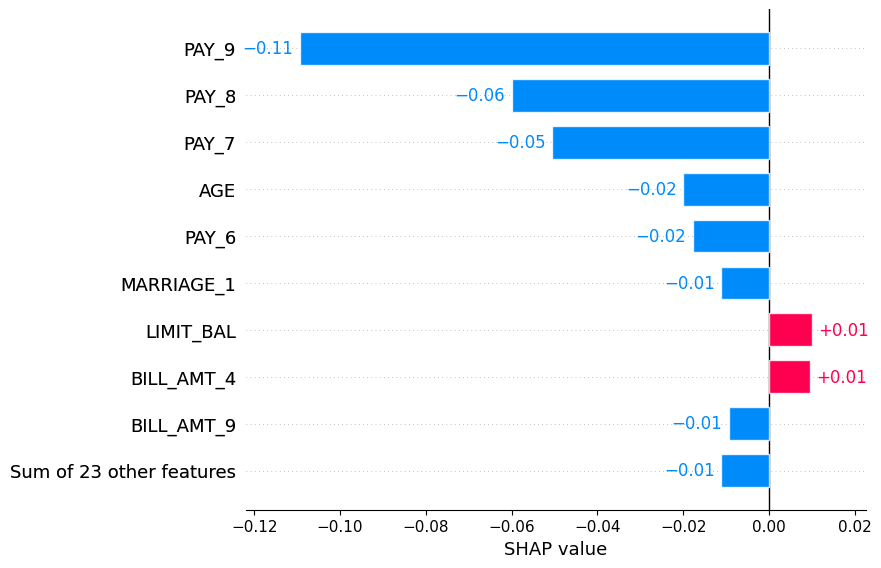

In [18]:
shap.plots.bar(shap_values[9])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


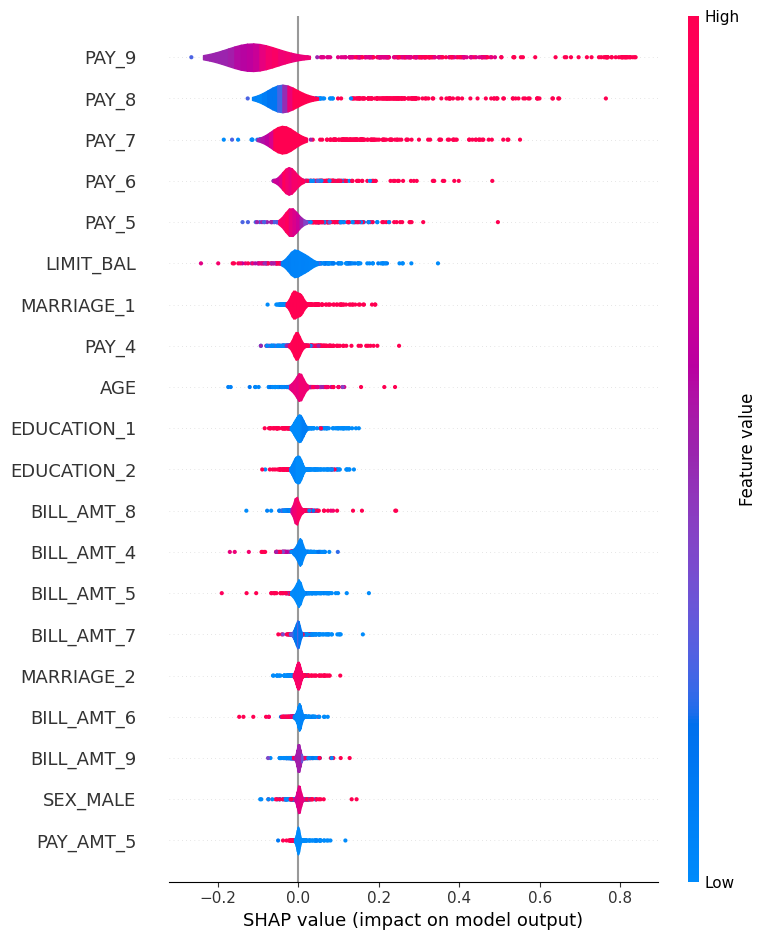

In [19]:
shap.summary_plot(shap_values, plot_type='violin')

### LIME

157/157 [==============================] - 0s 610us/step
[('EDUCATION_4 <= 0.00', 0.13997324283832763), ('0.10 < PAY_9 <= 0.20', -0.128388864863702), ('EDUCATION_5 <= 0.00', 0.10099584106914099), ('0.10 < PAY_8 <= 0.20', -0.09791678524568598), ('MARRIAGE_0 <= 0.00', 0.06985778109311168), ('EDUCATION_6 <= 0.00', -0.061174475679922916), ('0.00 < EDUCATION_1 <= 1.00', -0.047516874575228116), ('0.10 < PAY_7 <= 0.20', -0.04457931256358753), ('BILL_AMT_5 > 0.22', -0.03900354741844943), ('BILL_AMT_4 > 0.39', -0.03137809800999934), ('0.10 < PAY_5 <= 0.20', -0.03105072007471987), ('MARRIAGE_3 <= 0.00', 0.030354014228426634), ('MARRIAGE_1 <= 0.00', -0.029121837871994252), ('0.10 < PAY_6 <= 0.20', -0.028642970443192133), ('EDUCATION_0 <= 0.00', 0.02693086066388013), ('0.10 < PAY_4 <= 0.20', -0.023644314771351232), ('0.00 < MARRIAGE_2 <= 1.00', 0.021824295186965145), ('BILL_AMT_8 > 0.22', 0.01864107280878525), ('0.21 < LIMIT_BAL <= 0.35', -0.01718283436904768), ('AGE <= 0.13', -0.01653654595482085

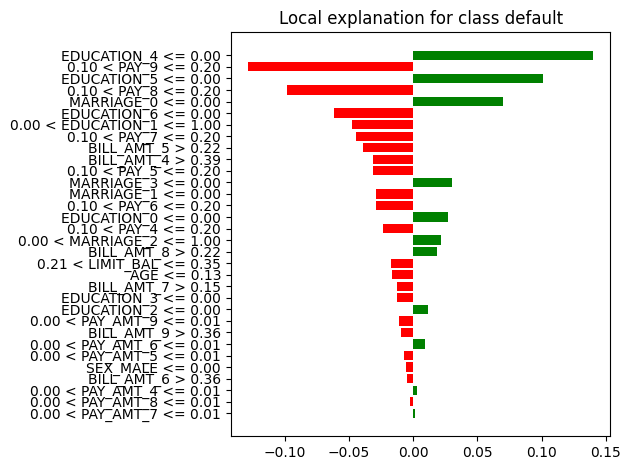

In [20]:
# Test LIME on Isolation Forest to check why it performs that bad
from lime import lime_tabular
from lime import lime_image

# Define the tabular lime explainer
explainer = lime_tabular.LimeTabularExplainer(training_data=X_train.values,
    feature_names=X_train.columns,
    class_names=['did not default', 'default'],
    mode='classification')

# Try to explain a prediction on a sample
n_features = len(X_train.columns)
exp = explainer.explain_instance(predict_fn=cnn_model.predict_proba, data_row=X_test.iloc[1], num_features=n_features)

# Plot the Local explanation for class default
exp.as_pyplot_figure()
plt.tight_layout()
print(exp.as_list())

### Permutation feature importance

In [21]:
# Compute Permutation Feature Importance on Isolation Forest to check why it performs that bad
from sklearn.inspection import permutation_importance

r = permutation_importance(cnn_model, X_test.iloc[:1000], y_test.iloc[:1000], n_repeats=30, random_state=42, scoring='f1')



32/32 [==============================] - 0s 654us/step


In [22]:
for i in r.importances_mean.argsort()[::-1]:
    print(f"{X_train.columns[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

PAY_9   0.138 +/- 0.014
PAY_8   0.059 +/- 0.011
PAY_7   0.036 +/- 0.010
PAY_6   0.028 +/- 0.006
PAY_5   0.028 +/- 0.009
EDUCATION_20.012 +/- 0.006
BILL_AMT_50.012 +/- 0.006
PAY_4   0.011 +/- 0.004
EDUCATION_10.011 +/- 0.007
BILL_AMT_80.010 +/- 0.003
BILL_AMT_60.010 +/- 0.005
BILL_AMT_70.009 +/- 0.005
PAY_AMT_50.008 +/- 0.004
MARRIAGE_20.007 +/- 0.004
LIMIT_BAL0.007 +/- 0.005
PAY_AMT_40.007 +/- 0.005
BILL_AMT_40.007 +/- 0.006
MARRIAGE_10.006 +/- 0.005
AGE     0.005 +/- 0.004
BILL_AMT_90.004 +/- 0.004
PAY_AMT_60.004 +/- 0.003
PAY_AMT_70.002 +/- 0.002
PAY_AMT_80.002 +/- 0.001
EDUCATION_50.002 +/- 0.002
EDUCATION_40.001 +/- 0.001
EDUCATION_30.000 +/- 0.005
SEX_MALE0.000 +/- 0.002
EDUCATION_60.000 +/- 0.000
MARRIAGE_30.000 +/- 0.000
EDUCATION_00.000 +/- 0.000
MARRIAGE_00.000 +/- 0.000
PAY_AMT_9-0.001 +/- 0.001
